# Dispersion analysis
## Simple script to open JSON and pickle data

In [1]:
import jpype
jpype.startJVM(jpype.getDefaultJVMPath())

In [2]:
from cpymad.madx import Madx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import glob
import json
import pybt
from pybt.tools.parsers import read_twiss_file
from pybt.myjson.encoder import myJSONDecoder
from os import walk
import skimage
from skimage import filters
from scipy import integrate
from matplotlib.pyplot import cm
import pickle
from scipy.optimize import curve_fit
from datetime import datetime

def gaussian_function(x, a, I, mu, sig):git cgssdgsdgsg
    return a + I / np.sqrt(2 * np.pi * sig ** 2) * np.exp(-(x - mu) ** 2 / 2. / sig ** 2)

def do_gaussian_fit(x,y):
    mu = np.average(x, weights=np.abs(y - np.min(y)))
    sigma = np.sqrt(np.average(x**2, weights=np.abs(y - np.min(y))) - mu**2)
    p0 = [y.min(), (np.max(y) - np.min(y)) * np.sqrt(2 * np.pi * sigma**2), mu, sigma]
    popt, pcov = curve_fit(gaussian_function, x, y, p0=p0, maxfev=1000) # maxfev is the number of tries it does the fit
    return popt, pcov

def create_elliptical_mask(h, w, center=None, radius=None, a=None, b=None):

    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt( ((X - center[0])**2)/(a**2) + ((Y-center[1])**2)/(b**2) )

    mask = dist_from_center <= radius
    return mask

# Create a Dataframe will all data

In [3]:
start_path = "/eos/user/e/eljohnso/SWAN_projects/"
end_path = "dispersion_measurement_data/"
mypath = start_path+"/"+end_path

f = []
for (dirpath, dirnames, filenames) in walk(mypath):
    f.extend(filenames)
    break

In [4]:
dirnames

['dispersion_measurement_data_2022_07_06_11h00m31s',
 'dispersion_measurement_data_2022_07_06_12h09m34s',
 'dispersion_measurement_data_quad_scan_2022_07_06_12h35m14s',
 'dispersion_measurement_data_quad_scan_2022_07_06_12h48m47s',
 'dispersion_measurement_data_quad_scan_2022_07_06_13h03m10s',
 'dispersion_measurement_data_quad_scan_2022_07_06_13h08m46s',
 'dispersion_measurement_data_quad_scan_2022_07_06_13h14m39s',
 'dispersion_measurement_data_quad_scan_2022_07_06_13h20m14s']

In [5]:
# Take the last image
subset_dirnames = [dirnames[0]]
subset_dirnames

['dispersion_measurement_data_2022_07_06_11h00m31s']

In [6]:
btv_name = "F61D.BTV010/Image"
df = pd.DataFrame(data = {"time": [], "Image": [], "Image_processed": [], "Acqu": [], "Intensity": [], "Filter": [], "sigmaSet1": [],
                          "i_qfn01": [], "i_qdn02": [], "i_qfn03": [],
                          "k_qfn01": [], "k_qdn02": [], "k_qfn03": [],
                          #"i_func_qfn01": [],
                          "i_func_qdn02": [],
#                           "i_func_qfn03": [],
#                           "i_oasis_qfn01": [], "i_oasis_qdn02": [], "i_oasis_qfn03": [],
                          "grpos": [],
                          "acqTimeInCycle": [],
                         })
for dirname in subset_dirnames:
    print (dirname)
    infile = open("../dispersion_measurement_data/"+dirname+"/"+dirname+".p", 'rb')
    loaded_pickle = pickle.load(infile)
    
    pixel_y = len(loaded_pickle[2][btv_name][0]["imagePositionSet2"][0])

    for j in range(len(loaded_pickle[0])):
        for i in range(6):
            try:
                image = loaded_pickle[2][btv_name][j]["imageSet"][i]
                reshaped_image = image.reshape(pixel_y,-1)
                reshaped_image = reshaped_image/4095 #Normalize
                med_filter_image = filters.median(reshaped_image, np.ones((3, 3)))

                try:
                    df2 = pd.DataFrame(data = {"time": loaded_pickle[0][j],
                                                "Image": [reshaped_image], "Image_processed": [med_filter_image], "Acqu": [i],
                                               "Intensity": [loaded_pickle[5][j]],
                                               "Filter": [loaded_pickle[2][btv_name][j]["filterSelect"][1]],
                                               "sigmaSet1": loaded_pickle[2][btv_name][j]["sigmaSet1"][i],
                                               "i_qfn01": loaded_pickle[3]["F61.QFN01/MEAS.PULSE#VALUE"][j],
                                               "i_qdn02": loaded_pickle[3]["F61.QDN02/MEAS.PULSE#VALUE"][j],
                                               "i_qfn03": loaded_pickle[3]["F61.QFN03/MEAS.PULSE#VALUE"][j],
                                               "k_qfn01": loaded_pickle[4]["logical.F61.QFN01/K_FUNC_LIST#value"][j][0][1][0],
                                               "k_qdn02": loaded_pickle[4]["logical.F61.QDN02/K_FUNC_LIST#value"][j][0][1][0],
                                               "k_qfn03": loaded_pickle[4]["logical.F61.QFN03/K_FUNC_LIST#value"][j][0][1][0],
    #                                            "i_func_qfn01": loaded_pickle[6]["logical.F61.QFN01/I_FUNC_LIST#value"][j][0],
                                               "i_func_qdn02": [loaded_pickle[6]["logical.F61.QDN02/I_FUNC_LIST#value"][j][0]],
                                               "i_func_qfn03": [loaded_pickle[6]["logical.F61.QFN03/I_FUNC_LIST#value"][j][0]],
                                               "i_oasis_qfn01": [loaded_pickle[7]["F61.QFN01/LOG.OASIS.I_MEAS#DATA"][j]],
                                               "i_oasis_qdn02": [loaded_pickle[7]["F61.QDN02/LOG.OASIS.I_MEAS#DATA"][j]],
                                               "i_oasis_qfn03": [loaded_pickle[7]["F61.QFN03/LOG.OASIS.I_MEAS#DATA"][j]],
                                               "grpos": [loaded_pickle[9]["PA.GSRPOS/Amplitude"][j]["amplitude"]],
                                               "acqTimeInCycle": [loaded_pickle[2][btv_name][j]["acqTimeInCycle"][i]]
                                              })
                except:
                    print("here")
                df = pd.concat([df,df2])
            except:
                print("error")
                pass
df.reset_index(drop=True, inplace=True)

# Add saturation colum
saturation_list = []
for i in range(len(df)):
    saturation_list.append((df.iloc[i].Image == 1).sum())
df["Saturation"] = saturation_list
saturation_list = []
for i in range(len(df)):
    saturation_list.append((df.iloc[i].Image_processed == 255).sum())
df["Saturation_processed"] = saturation_list

# Add start spill time column
start_spill_list = []
for i in range(len(df)):
    start_spill_list.append(1258 + ((df.iloc[i].grpos)+7)*325/14)
df["start_spill"] = start_spill_list

# # Add spill time column
spill_time_list = []
for i in range(len(df)):
    spill_time_list.append(df.iloc[i].acqTimeInCycle - df.iloc[i].start_spill)
df["time_spill"] = spill_time_list
    
df.head(5)

dispersion_measurement_data_2022_07_06_11h00m31s


/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/skimage/util/dtype.py:140: UserWarning: Possible precision loss when converting from float64 to uint8
  warn("Possible precision loss when converting from {} to {}"


time  \
0 2022-07-06 11:00:44.539777   
1 2022-07-06 11:00:44.539777   
2 2022-07-06 11:00:44.539777   
3 2022-07-06 11:00:44.539777   
4 2022-07-06 11:00:44.539777   

                                               Image  \
0  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
1  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
2  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
3  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
4  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   

                                     Image_processed  Acqu  Intensity Filter  \
0  [[1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1,...   0.0  19.687176  THIRD   
1  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   1.0  19.687176  THIRD   
2  [[1, 0, 0, 0, 1, 1, 1, 2, 2, 2, 2, 4, 4, 3, 3,...   2.0  19.687176  THIRD   
3  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   3.0  19.687176  THIRD   
4  [[1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 2, 2,...   4.0  19.687176  THIRD   

       sigmaSet1     i_qfn01     i_qdn02    i_qfn03  ...  grpos  \
0  3.952525e-323  624.080261  405.705017  381.21051  ...   -7.0   
1   7.716546e-01  624.080261  405.705017  381.21051  ...   -7.0   
2   1.722316e+00  624.080261  405.705017  381.21051  ...   -7.0   
3   1.951504e+00  624.080261  405.705017  381.21051  ...   -7.0   
4  4.446591e-323  624.080261  405.705017  381.21051  ...   -7.0   

   acqTimeInCycle                                       i_func_qfn03  \
0          1121.0  [[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0,...   
1          1221.0  [[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0,...   
2          1321.0  [[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0,...   
3          1421.0  [[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0,...   
4          1521.0  [[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0,...   

                                       i_oasis_qfn01  \
0  [0.004600878, 0.00364151, 0.0039249924, 0.0029...   
1  [0.004600878, 0.00364151, 0.0039249924, 0.0029...   
2  [0.004600878, 0.00364151, 0.0039249924, 0.0029...   
3  [0.004600878, 0.00364151, 0.0039249924, 0.0029...   
4  [0.004600878, 0.00364151, 0.0039249924, 0.0029...   

                                       i_oasis_qdn02  \
0  [0.0007196069, 0.0003489931, -0.0016348772, -0...   
1  [0.0007196069, 0.0003489931, -0.0016348772, -0...   
2  [0.0007196069, 0.0003489931, -0.0016348772, -0...   
3  [0.0007196069, 0.0003489931, -0.0016348772, -0...   
4  [0.0007196069, 0.0003489931, -0.0016348772, -0...   

                                       i_oasis_qfn03 Saturation  \
0  [-0.00041428697, -0.0001090602, -0.0005887237,...          0   
1  [-0.00041428697, -0.0001090602, -0.0005887237,...          0   
2  [-0.00041428697, -0.0001090602, -0.0005887237,...         30   
3  [-0.00041428697, -0.0001090602, -0.0005887237,...          0   
4  [-0.00041428697, -0.0001090602, -0.0005887237,...          0   

  Saturation_processed start_spill time_spill  
0                    0      1258.0     -137.0  
1                    0      1258.0      -37.0  
2                    0      1258.0       63.0  
3                    0      1258.0      163.0  
4                    0      1258.0      263.0  

[5 rows x 24 columns]

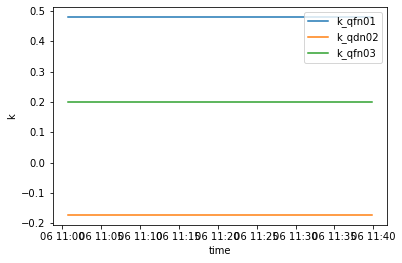

In [7]:
fig, ax = plt.subplots()
ax.plot(df.time, df.k_qfn01, label=f"k_qfn01")
ax.plot(df.time, df.k_qdn02, label=f"k_qdn02")
ax.plot(df.time, df.k_qfn03, label=f"k_qfn03")
ax.set_ylabel("k")
ax.set_xlabel("time")
ax.legend()

In [8]:
loaded_pickle[8]["PA.FREV-SD/Samples"][0]

{'superCycleDuration': 35,
 'firstSampleTime': 150.0,
 'cycleTimeStamp': 1657098036700000000,
 'hotSpotsTimes': array([170., 728.]),
 'firstSampleTime_units': 'ms',
 'hotSpotsSamples_units': 'kHz',
 'samples_units': 'kHz',
 'hotSpotsNames': array(['Inj.', 'Ej.'], dtype='<U4'),
 'beamDestinationName': 'EAST_DMP',
 'particleName': 'PROTON',
 'samplingTrain_units': 'ms',
 'samplingTrain': 1.0,
 'timeUnitFactor': 0.001,
 'basicPeriodMilliSecond': 1200,
 'samples': array([452.37064362, 452.3730278 , 452.36945152, ..., 476.80646181,
        476.80348158, 476.80705786]),
 'hotSpotsTimes_units': 'ms',
 'hotSpotsSamples': array([452.36676931, 476.62585974]),
 'samplingStates': 0,
 'cyclePosition': 24,
 'cycleDuration': 2,
 'cycleUserName': 'CPS.USER.MD3'}

Text(0.5, 0, '[]')

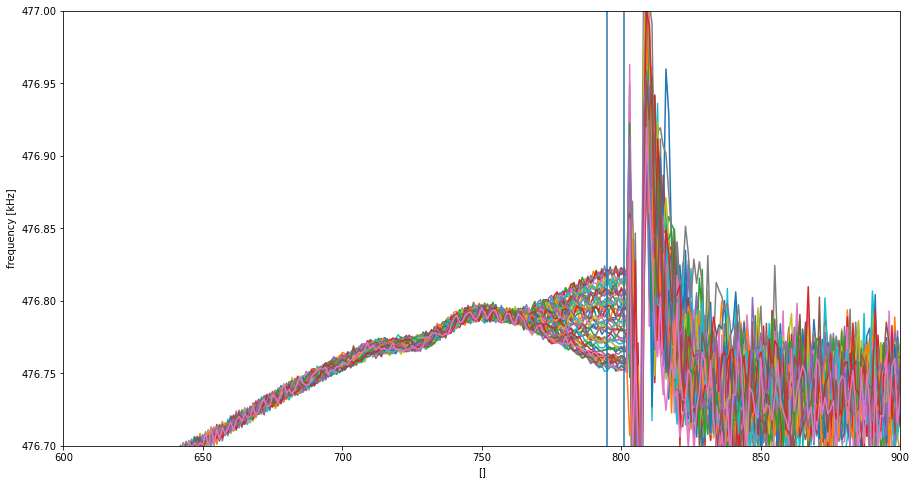

In [9]:
fig, ax = plt.subplots(figsize=(15,8))
for i in range(len(loaded_pickle[8]["PA.FREV-SD/Samples"])):
    samples = loaded_pickle[8]["PA.FREV-SD/Samples"][i]["samples"]
    ax.plot(samples)
    ax.set_xlim(600,900)
    ax.set_ylim(476.7,477)
ax.axvline(801)
ax.axvline(801-6)
ax.set_ylabel("frequency [kHz]")
ax.set_xlabel("[]")

Text(0, 0.5, 'Frequency [kHz]')

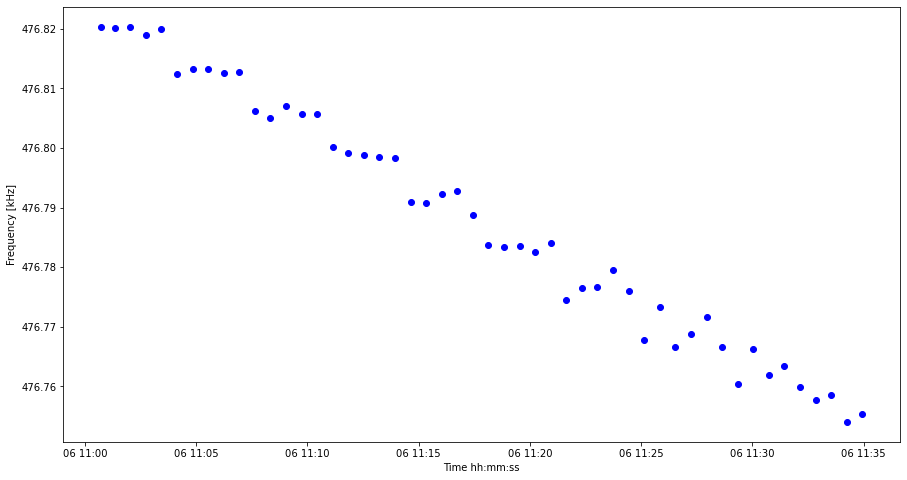

In [10]:
x = []
y = []
mean_frev = []
fig, ax = plt.subplots(figsize=(15,8))
for i in range(50):
    x = (loaded_pickle[0][i])

    last_samples = []
    for j in range(6):
        sample = loaded_pickle[8]["PA.FREV-SD/Samples"][i]["samples"][801-j]
        last_samples.append(sample)
    y = np.mean(np.array(last_samples))
    mean_frev.append(y)
    
    ax.scatter(x,y, marker="o", c="b")
ax.set_xlabel("Time hh:mm:ss")
ax.set_ylabel("Frequency [kHz]")

[476.820170879364, 476.81257128715515, 476.80591543515527, 476.7992595831553, 476.78987185160315, 476.7838617165883, 476.7752687136332, 476.7697552839915, 476.7650365829468, 476.75758600234985]


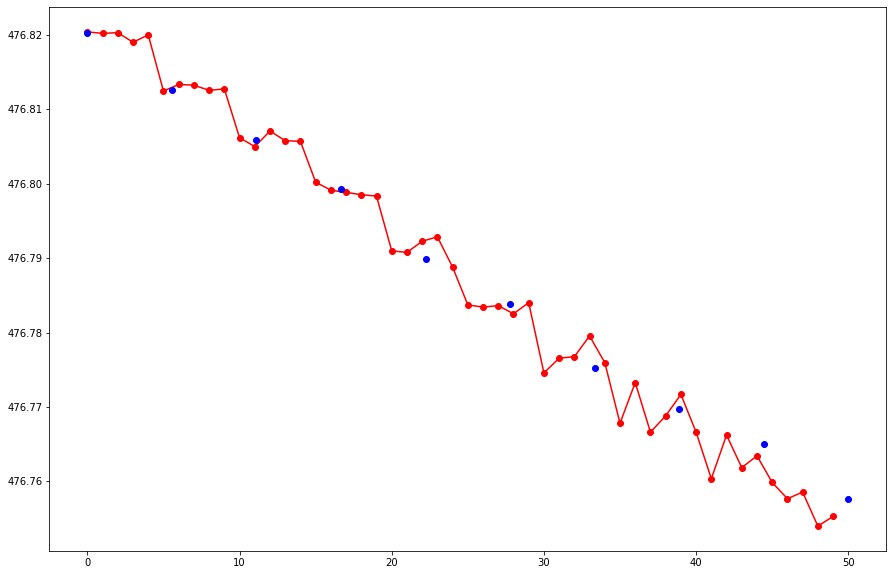

In [11]:
data = [2.34, 3.45, 4.56, 1.23, 2.34, 7.89]
mean_mean_frev = [(a + b) / 2 for a, b in zip(mean_frev[::5], mean_frev[4::5])]
print (mean_mean_frev)
fig, ax = plt.subplots(figsize=(15,10))
ax.scatter(np.linspace(0,50,10), mean_mean_frev, marker="o", color="b", zorder=99)
ax.plot(mean_frev, marker="o", color="r")

In [12]:
loaded_pickle[9]["PA.GSRPOS/Amplitude"][0]["amplitude"]

-7.0

In [13]:
x = []
y = []
fig, ax = plt.subplots(figsize=(15,8))
for i in range(len(loaded_pickle[9]["PA.GSRPOS/Amplitude"])):
    x.append(loaded_pickle[0][i])
    y.append(loaded_pickle[9]["PA.GSRPOS/Amplitude"][i]["amplitude"])
ax.plot(x,y, marker="o")
#     ax.set_xlim(600,900)
#     ax.set_ylim(476.7,477)
ax.set_xlabel("Time hh:mm:ss")
ax.set_ylabel("GSRPOS [mm]")
grpos = np.unique(np.array(y))
print(np.unique(np.array(y)))

[-7.         -5.44444444 -3.88888889 -2.33333333 -0.77777778  0.77777778
  2.33333333  3.88888889  5.44444444  7.        ]


Text(0, 0.5, '$\\overline{frev}$ [mm]')

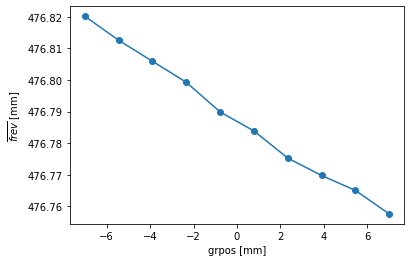

In [14]:
fig, ax = plt.subplots()
ax.plot(grpos,mean_mean_frev, marker="o")
ax.set_xlabel("grpos [mm]")
ax.set_ylabel("$\overline{frev}$ [mm]")

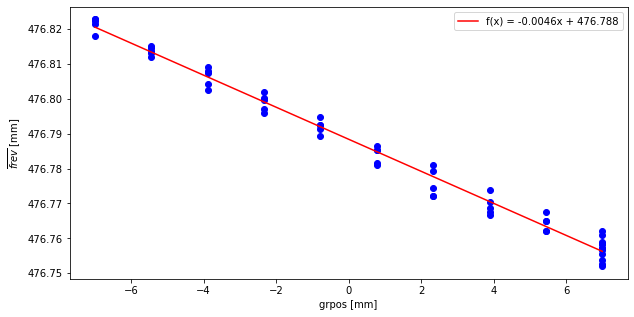

In [15]:
fig, ax = plt.subplots(figsize=(10,5))

x = []
y = []
for i in range(len(loaded_pickle[9]["PA.GSRPOS/Amplitude"])):
    x.append(loaded_pickle[9]["PA.GSRPOS/Amplitude"][i]["amplitude"])
    y.append(loaded_pickle[8]["PA.FREV-SD/Samples"][i]["samples"][800])    

x = np.array(x)
ax.scatter(x, y, marker="o", color="b")

res = stats.linregress(x, y)
ax.plot(x, res.intercept + res.slope*x, color="r", label=f"f(x) = {round(res.slope,5)}x + {round(res.intercept,3)}")
ax.set_xlabel("grpos [mm]")
ax.set_ylabel("$\overline{frev}$ [mm]")
ax.legend()

# Add a frequency column

In [16]:
# Add frequency colums
frev_list = []

for i in range(len(df)):
    frev = -0.004596494826949946*df.iloc[i].grpos + 476.7884378924089
    frev_list.append(frev)
df["frev"] = frev_list

## Add fit for Image_processed

In [17]:
# Add fitting colums
gaussian_maxH_list = []
gaussian_maxV_list = []

poptH0_list = []
poptH1_list = []
poptH2_list = []
poptH3_list = []

poptV0_list = []
poptV1_list = []
poptV2_list = []
poptV3_list = []

muH_list = []
muH_err_list = []
muV_list = []
muV_err_list = []

sigH_list = []
sigH_err_list = []
sigV_list = []
sigV_err_list = []

integralH_list = []
integralV_list = []


for i in range(len(df)):

    try:
        Image_processed = df.iloc[i].Image_processed.copy()

        Hy = Image_processed.sum(axis=0)
        Hx = np.linspace(0, len(Hy)-1, len(Hy))

        Vy = Image_processed.sum(axis=1)
        Vx = np.linspace(0, len(Vy)-1, len(Vy))

        # H
        poptH, pcovH = do_gaussian_fit(Hx, Hy)

        gaussian_maxH = gaussian_function(Hx, poptH[0], poptH[1], poptH[2], poptH[3]).max()

        # V
        poptV, pcovV = do_gaussian_fit(Vx, Vy)

        gaussian_maxV = gaussian_function(Vx, poptV[0], poptV[1], poptV[2], poptV[3]).max()

        gaussian_maxH_list.append(gaussian_maxH)
        gaussian_maxV_list.append(gaussian_maxV)
        
        poptH0_list.append(poptH[0])
        poptH1_list.append(poptH[1])
        poptH2_list.append(poptH[2])
        poptH3_list.append(poptH[3])
        
        poptV0_list.append(poptV[0])
        poptV1_list.append(poptV[1])
        poptV2_list.append(poptV[2])
        poptV3_list.append(poptV[3])

        
        muH_list.append(poptH[2])
        muH_err_list.append(pcovH[2, 2] ** 0.5)
        muV_list.append(poptV[2])
        muV_err_list.append(pcovV[2, 2] ** 0.5)
        
        sigH_list.append(poptH[3])
        sigH_err_list.append(pcovH[3, 3] ** 0.5)
        sigV_list.append(poptV[3])
        sigV_err_list.append(pcovV[3, 3] ** 0.5)
        
        try:
            #Integration
            x = np.linspace(0,300,300)
            gaussH = lambda x: gaussian_function(x, poptH[0], poptH[1], poptH[2], poptH[3])
            integralH = (integrate.quad(gaussH, 0, 300))

            gaussV = lambda x: gaussian_function(x, poptV[0], poptV[1], poptV[2], poptV[3])
            integralV = (integrate.quad(gaussV, 0, 300))

            integralH_list.append(integralH[0])
            integralV_list.append(integralV[0])
        except:
            print("failed integration")
            pass
            
        
    except:
        gaussian_maxH_list.append(np.nan)
        gaussian_maxV_list.append(np.nan)

        poptH0_list.append(np.nan)
        poptH1_list.append(np.nan)
        poptH2_list.append(np.nan)
        poptH3_list.append(np.nan)
        
        poptV0_list.append(np.nan)
        poptV1_list.append(np.nan)
        poptV2_list.append(np.nan)
        poptV3_list.append(np.nan)
        
        muH_list.append(np.nan)
        muH_err_list.append(np.nan)
        muV_list.append(np.nan)
        muV_err_list.append(np.nan)
        
        sigH_list.append(np.nan)
        sigH_err_list.append(np.nan)
        sigV_list.append(np.nan)
        sigV_err_list.append(np.nan)
        
        integralH_list.append(np.nan)
        integralV_list.append(np.nan)
#         print("Failed fit")

# df["gaussian_maxH_proc"] = gaussian_maxH_list
# df["gaussian_maxV_proc"] = gaussian_maxV_list

# df["poptH0_proc"] = poptH0_list
# df["poptH1_proc"] = poptH1_list
# df["poptH2_proc"] = poptH2_list
# df["poptH3_proc"] = poptH3_list
df["muH_proc"] = muH_list
# df["muErrH_proc"] = muH_err_list
df["sigH_proc"] = sigH_list
# df["sigErrH_proc"] = sigH_err_list


# df["poptV0_proc"] = poptV0_list
# df["poptV1_proc"] = poptV1_list
# df["poptV2_proc"] = poptV2_list
# df["poptV3_proc"] = poptV3_list
df["muV_proc"] = muV_list
# df["muErrV_proc"] = muV_err_list
df["sigV_proc"] = sigV_list
# df["sigErrV_proc"] = sigV_err_list

# df["integralH_proc"] = integralH_list
# df["integralV_proc"] = integralV_list
print (f"{len(df[np.isnan(df.muH_proc)].muH_proc)}/{len(df)} failed fit")

print (f"muH: {int(df.muH_proc.median())}")
print (f"muV: {int(df.muV_proc.median())}")
print (f"sigH: {int(df.sigH_proc.median())}")
print (f"sigV: {int(df.sigV_proc.median())}")

/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


195/342 failed fit
muH: 147
muV: -58
sigH: 46
sigV: 24


### Add a column with masked processed image using the median of the fit on the processed image to feed the ellipse center and radii

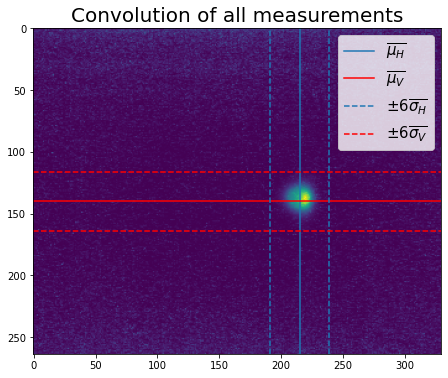

In [18]:
sum_image = np.zeros(shape=(264, 330))
for i in range(len(df)):
    sum_image = sum_image + df.iloc[i].Image
fig, ax = plt.subplots(figsize=(10,6))
ax.imshow(sum_image)

#Override the mask
muH_median = 215
muV_median = 140
sigH_median = 4
sigV_median = 4

ax.axvline(muH_median, label = "$\overline{\mu_{H}}$")
ax.axhline(muV_median, color="r", label = "$\overline{\mu_{V}}$")

ax.axvline(muH_median + 6*sigH_median, linestyle="--", label="$\pm6\overline{\sigma_{H}}$")
ax.axvline(muH_median - 6*sigH_median, linestyle="--")

ax.axhline(muV_median + 6*sigV_median, linestyle="--", color="r", label="$\pm6\overline{\sigma_{V}}$")
ax.axhline(muV_median - 6*sigV_median, linestyle="--", color="r")
ax.set_title("Convolution of all measurements", fontsize=20)
ax.legend(fontsize=15)

In [19]:
# Add masked colum
image_processed_masked_list = []
for i in range(len(df)):
    
    image_processed_masked = df.iloc[i].Image_processed.copy()
    
    h, w = image_processed_masked.shape[:2]
    mask = create_elliptical_mask(h, w, center=(muH_median,muV_median), radius = 1, a=6*sigH_median, b=6*sigV_median)
    masked_img = image_processed_masked.copy()
    masked_img[~mask] = 0

    image_processed_masked_list.append(masked_img)
    
df["Image_processed_masked"] = image_processed_masked_list
df.head(1)

time  \
0 2022-07-06 11:00:44.539777   

                                               Image  \
0  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   

                                     Image_processed  Acqu  Intensity Filter  \
0  [[1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1,...   0.0  19.687176  THIRD   

       sigmaSet1     i_qfn01     i_qdn02    i_qfn03  ...  Saturation  \
0  3.952525e-323  624.080261  405.705017  381.21051  ...           0   

   Saturation_processed  start_spill time_spill        frev    muH_proc  \
0                     0       1258.0     -137.0  476.820613  141.870092   

   sigH_proc  muV_proc  sigV_proc  \
0  50.472326 -61.64785 -40.574795   

                              Image_processed_masked  
0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  

[1 rows x 30 columns]

Text(0.5, 1.0, 'Masked image')

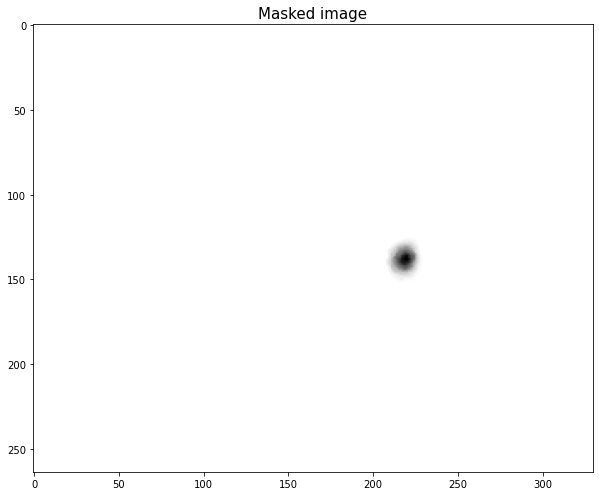

In [20]:
fig, ax = plt.subplots(figsize=(10,7),tight_layout=True)
ax.imshow(df.Image_processed_masked[8], cmap = "Greys")
ax.set_title("Masked image", fontsize=15)

In [21]:
fig, ax = plt.subplots(figsize=(10,7),tight_layout=True)
ax.imshow(df.Image_processed_masked[0], cmap = "Greys")
ax.set_title("Masked image", fontsize=15)

Text(0.5, 1.0, 'Masked image')

## Add fit for Image_processed_masked

In [22]:
# Add fitting colums
gaussian_maxH_list = []
gaussian_maxV_list = []

poptH0_list = []
poptH1_list = []
poptH2_list = []
poptH3_list = []

poptV0_list = []
poptV1_list = []
poptV2_list = []
poptV3_list = []

muH_list = []
muH_err_list = []
muV_list = []
muV_err_list = []

sigH_list = []
sigH_err_list = []
sigV_list = []
sigV_err_list = []

integralH_list = []
integralV_list = []


for i in range(len(df)):

    try:
        image_processed_masked = df.iloc[i].Image_processed_masked.copy()

        Hy = image_processed_masked.sum(axis=0)
        Hx = np.linspace(0, len(Hy)-1, len(Hy))

        Vy = image_processed_masked.sum(axis=1)
        Vx = np.linspace(0, len(Vy)-1, len(Vy))

        # H
        poptH, pcovH = do_gaussian_fit(Hx, Hy)

        gaussian_maxH = gaussian_function(Hx, poptH[0], poptH[1], poptH[2], poptH[3]).max()

        # V
        poptV, pcovV = do_gaussian_fit(Vx, Vy)

        gaussian_maxV = gaussian_function(Vx, poptV[0], poptV[1], poptV[2], poptV[3]).max()

        gaussian_maxH_list.append(gaussian_maxH)
        gaussian_maxV_list.append(gaussian_maxV)
        
        poptH0_list.append(poptH[0])
        poptH1_list.append(poptH[1])
        poptH2_list.append(poptH[2])
        poptH3_list.append(poptH[3])
        
        poptV0_list.append(poptV[0])
        poptV1_list.append(poptV[1])
        poptV2_list.append(poptV[2])
        poptV3_list.append(poptV[3])

        
        muH_list.append(poptH[2])
        muH_err_list.append(pcovH[2, 2] ** 0.5)
        muV_list.append(poptV[2])
        muV_err_list.append(pcovV[2, 2] ** 0.5)
        
        sigH_list.append(poptH[3])
        sigH_err_list.append(pcovH[3, 3] ** 0.5)
        sigV_list.append(poptV[3])
        sigV_err_list.append(pcovV[3, 3] ** 0.5)
        
        try:
            #Integration
            x = np.linspace(-300,300,300)
            gaussH = lambda x: gaussian_function(x, poptH[0], poptH[1], poptH[2], poptH[3])
            integralH = (integrate.quad(gaussH, -300, 300))

            gaussV = lambda x: gaussian_function(x, poptV[0], poptV[1], poptV[2], poptV[3])
            integralV = (integrate.quad(gaussV, -300, 300))

            integralH_list.append(integralH[0])
            integralV_list.append(integralV[0])
        except:
            print("failed integration")
            pass
            
        
    except:
        gaussian_maxH_list.append(np.nan)
        gaussian_maxV_list.append(np.nan)

        poptH0_list.append(np.nan)
        poptH1_list.append(np.nan)
        poptH2_list.append(np.nan)
        poptH3_list.append(np.nan)
        
        poptV0_list.append(np.nan)
        poptV1_list.append(np.nan)
        poptV2_list.append(np.nan)
        poptV3_list.append(np.nan)
        
        muH_list.append(np.nan)
        muH_err_list.append(np.nan)
        muV_list.append(np.nan)
        muV_err_list.append(np.nan)
        
        sigH_list.append(np.nan)
        sigH_err_list.append(np.nan)
        sigV_list.append(np.nan)
        sigV_err_list.append(np.nan)
        
        integralH_list.append(np.nan)
        integralV_list.append(np.nan)
        print("Failed fit")

df["gaussian_maxH"] = gaussian_maxH_list
df["gaussian_maxV"] = gaussian_maxV_list

df["poptH0"] = poptH0_list
df["poptH1"] = poptH1_list
df["poptH2"] = poptH2_list
df["poptH3"] = poptH3_list
df["muH"] = muH_list
df["muErrH"] = muH_err_list
df["sigH"] = sigH_list
df["sigErrH"] = sigH_err_list


df["poptV0"] = poptV0_list
df["poptV1"] = poptV1_list
df["poptV2"] = poptV2_list
df["poptV3"] = poptV3_list
df["muV"] = muV_list
df["muErrV"] = muV_err_list
df["sigV"] = sigV_list
df["sigErrV"] = sigV_err_list

df["integralH"] = integralH_list
df["integralV"] = integralV_list

print (f"{len(df[np.isnan(df.muH)].muH_proc)}/{len(df)} failed fit")

Failed fit
Failed fit
Failed fit
Failed fit


/tmp/ipykernel_852/2704832773.py:22: RuntimeWarning: invalid value encountered in double_scalars
  return a + I / np.sqrt(2 * np.pi * sig ** 2) * np.exp(-(x - mu) ** 2 / 2. / sig ** 2)
/tmp/ipykernel_852/2704832773.py:22: RuntimeWarning: divide by zero encountered in true_divide
  return a + I / np.sqrt(2 * np.pi * sig ** 2) * np.exp(-(x - mu) ** 2 / 2. / sig ** 2)
/tmp/ipykernel_852/2704832773.py:22: RuntimeWarning: invalid value encountered in true_divide
  return a + I / np.sqrt(2 * np.pi * sig ** 2) * np.exp(-(x - mu) ** 2 / 2. / sig ** 2)
/tmp/ipykernel_852/2704832773.py:22: RuntimeWarning: divide by zero encountered in double_scalars
  return a + I / np.sqrt(2 * np.pi * sig ** 2) * np.exp(-(x - mu) ** 2 / 2. / sig ** 2)
/tmp/ipykernel_852/2704832773.py:22: RuntimeWarning: invalid value encountered in multiply
  return a + I / np.sqrt(2 * np.pi * sig ** 2) * np.exp(-(x - mu) ** 2 / 2. / sig ** 2)
/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc8-opt/lib/python3.9/site-p

Failed fit
Failed fit
Failed fit
Failed fit
Failed fit


/tmp/ipykernel_852/1730951887.py:81: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  integralV = (integrate.quad(gaussV, -300, 300))


Failed fit
Failed fit
Failed fit
Failed fit
Failed fit
Failed fit
Failed fit
Failed fit
Failed fit
Failed fit
Failed fit
Failed fit
Failed fit
Failed fit
Failed fit
Failed fit
Failed fit
Failed fit
Failed fit
Failed fit
Failed fit
Failed fit
Failed fit
Failed fit
Failed fit
Failed fit
Failed fit
Failed fit
Failed fit
Failed fit
Failed fit
Failed fit
Failed fit
Failed fit
Failed fit
Failed fit
Failed fit
Failed fit
Failed fit
Failed fit
Failed fit
Failed fit
Failed fit
Failed fit
53/342 failed fit


# Fit with pixel calibration

In [23]:
# Add fitting colums
gaussian_maxH_list = []
gaussian_maxV_list = []

poptH0_list = []
poptH1_list = []
poptH2_list = []
poptH3_list = []

poptV0_list = []
poptV1_list = []
poptV2_list = []
poptV3_list = []

muH_list = []
muH_err_list = []
muV_list = []
muV_err_list = []

sigH_list = []
sigH_err_list = []
sigV_list = []
sigV_err_list = []

integralH_list = []
integralV_list = []


for i in range(len(df)):

    try:
        image_processed_masked = df.iloc[i].Image_processed_masked.copy()

        Hy = image_processed_masked.sum(axis=0)
        Hx = np.linspace(min(loaded_pickle[1]["F61D.BTV010/Acquisition"][0]["projPositionSet1"][0]), max(loaded_pickle[1]["F61D.BTV010/Acquisition"][0]["projPositionSet1"][0]), len(image_processed_masked.sum(axis=0))) # Pixel calibration

        Vy = image_processed_masked.sum(axis=1)
        Vx = np.linspace(min(loaded_pickle[1]["F61D.BTV010/Acquisition"][0]["projPositionSet2"][0]), max(loaded_pickle[1]["F61D.BTV010/Acquisition"][0]["projPositionSet2"][0]), len(image_processed_masked.sum(axis=1)))

        # H
        poptH, pcovH = do_gaussian_fit(Hx, Hy)

        gaussian_maxH = gaussian_function(Hx, poptH[0], poptH[1], poptH[2], poptH[3]).max()

        # V
        poptV, pcovV = do_gaussian_fit(Vx, Vy)

        gaussian_maxV = gaussian_function(Vx, poptV[0], poptV[1], poptV[2], poptV[3]).max()

        gaussian_maxH_list.append(gaussian_maxH)
        gaussian_maxV_list.append(gaussian_maxV)
        
        poptH0_list.append(poptH[0])
        poptH1_list.append(poptH[1])
        poptH2_list.append(poptH[2])
        poptH3_list.append(poptH[3])
        
        poptV0_list.append(poptV[0])
        poptV1_list.append(poptV[1])
        poptV2_list.append(poptV[2])
        poptV3_list.append(poptV[3])

        
        muH_list.append(poptH[2])
        muH_err_list.append(pcovH[2, 2] ** 0.5)
        muV_list.append(poptV[2])
        muV_err_list.append(pcovV[2, 2] ** 0.5)
        
        sigH_list.append(poptH[3])
        sigH_err_list.append(pcovH[3, 3] ** 0.5)
        sigV_list.append(poptV[3])
        sigV_err_list.append(pcovV[3, 3] ** 0.5)
        
        try:
            #Integration
            x = np.linspace(-300,300,300)
            gaussH = lambda x: gaussian_function(x, poptH[0], poptH[1], poptH[2], poptH[3])
            integralH = (integrate.quad(gaussH, -300, 300))

            gaussV = lambda x: gaussian_function(x, poptV[0], poptV[1], poptV[2], poptV[3])
            integralV = (integrate.quad(gaussV, -300, 300))

            integralH_list.append(integralH[0])
            integralV_list.append(integralV[0])
        except:
            print("failed integration")
            pass
            
        
    except:
        gaussian_maxH_list.append(np.nan)
        gaussian_maxV_list.append(np.nan)

        poptH0_list.append(np.nan)
        poptH1_list.append(np.nan)
        poptH2_list.append(np.nan)
        poptH3_list.append(np.nan)
        
        poptV0_list.append(np.nan)
        poptV1_list.append(np.nan)
        poptV2_list.append(np.nan)
        poptV3_list.append(np.nan)
        
        muH_list.append(np.nan)
        muH_err_list.append(np.nan)
        muV_list.append(np.nan)
        muV_err_list.append(np.nan)
        
        sigH_list.append(np.nan)
        sigH_err_list.append(np.nan)
        sigV_list.append(np.nan)
        sigV_err_list.append(np.nan)
        
        integralH_list.append(np.nan)
        integralV_list.append(np.nan)
        print("Failed fit")

# df["gaussian_maxH"] = gaussian_maxH_list
# df["gaussian_maxV"] = gaussian_maxV_list

df["poptH0_cal"] = poptH0_list
df["poptH1_cal"] = poptH1_list
df["poptH2_cal"] = poptH2_list
df["poptH3_cal"] = poptH3_list
# df["muH"] = muH_list
df["muErrH_cal"] = muH_err_list
# df["sigH"] = sigH_list
df["sigErrH_cal"] = sigH_err_list


df["poptV0_cal"] = poptV0_list
df["poptV1_cal"] = poptV1_list
df["poptV2_cal"] = poptV2_list
df["poptV3_cal"] = poptV3_list
# df["muV"] = muV_list
df["muErrV_cal"] = muV_err_list
# df["sigV"] = sigV_list
df["sigErrV_cal"] = sigV_err_list

# df["integralH"] = integralH_list
# df["integralV"] = integralV_list

Failed fit
Failed fit
Failed fit
Failed fit
Failed fit
Failed fit
Failed fit


/tmp/ipykernel_852/2704832773.py:22: RuntimeWarning: invalid value encountered in double_scalars
  return a + I / np.sqrt(2 * np.pi * sig ** 2) * np.exp(-(x - mu) ** 2 / 2. / sig ** 2)
/tmp/ipykernel_852/2704832773.py:22: RuntimeWarning: divide by zero encountered in true_divide
  return a + I / np.sqrt(2 * np.pi * sig ** 2) * np.exp(-(x - mu) ** 2 / 2. / sig ** 2)
/tmp/ipykernel_852/2704832773.py:22: RuntimeWarning: invalid value encountered in true_divide
  return a + I / np.sqrt(2 * np.pi * sig ** 2) * np.exp(-(x - mu) ** 2 / 2. / sig ** 2)
/tmp/ipykernel_852/2704832773.py:22: RuntimeWarning: divide by zero encountered in double_scalars
  return a + I / np.sqrt(2 * np.pi * sig ** 2) * np.exp(-(x - mu) ** 2 / 2. / sig ** 2)
/tmp/ipykernel_852/2704832773.py:22: RuntimeWarning: invalid value encountered in multiply
  return a + I / np.sqrt(2 * np.pi * sig ** 2) * np.exp(-(x - mu) ** 2 / 2. / sig ** 2)
/tmp/ipykernel_852/699284542.py:78: IntegrationWarning: The occurrence of roundoff er

Failed fit
Failed fit
Failed fit
Failed fit


/tmp/ipykernel_852/699284542.py:81: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  integralV = (integrate.quad(gaussV, -300, 300))


Failed fit
Failed fit
Failed fit
Failed fit
Failed fit
Failed fit
Failed fit
Failed fit
Failed fit
Failed fit
Failed fit
Failed fit
Failed fit
Failed fit
Failed fit
Failed fit
Failed fit
Failed fit
Failed fit
Failed fit
Failed fit
Failed fit
Failed fit
Failed fit
Failed fit
Failed fit
Failed fit
Failed fit
Failed fit
Failed fit
Failed fit
Failed fit
Failed fit


/tmp/ipykernel_852/2704832773.py:26: RuntimeWarning: invalid value encountered in sqrt
  sigma = np.sqrt(np.average(x**2, weights=np.abs(y - np.min(y))) - mu**2)


Failed fit
Failed fit
Failed fit
Failed fit
Failed fit
Failed fit
Failed fit
Failed fit
Failed fit


In [24]:
# fig, ax = plt.subplots(figsize=(20,10))

# for Acqu in range(4):
#     Acqu=Acqu+2

#     for Filter in ["THIRD"]:
            
#         Saturation = df[df.Filter==Filter][df[df.Filter==Filter].Acqu==Acqu].Saturation
#         SignalH = df[df.Filter==Filter][df[df.Filter==Filter].Acqu==Acqu].gaussian_maxH
#         SignalV = df[df.Filter==Filter][df[df.Filter==Filter].Acqu==Acqu].gaussian_maxV
#         Intensity = df[df.Filter==Filter][df[df.Filter==Filter].Acqu==Acqu].Intensity

#         ax.scatter(Saturation, SignalH+SignalV, label=f"filter {Filter}")

#     ax.set_title(f"Acquisition {Acqu}", fontsize=20)
#     ax.legend()
#     ax.set_xlabel("Saturation #max pixel", fontsize=15)
#     ax.set_ylabel("Signal", fontsize=15)
#     ax.set_ylim(0, 25000)
#     ax.axhline(7500)

# Image processing

In [25]:
# dff3 = df[df.Filter=="THIRD"].copy()
# dff3a4 = dff3[dff3.Acqu==4].copy()
# for i in range(3):
#     try:
#         fig, ax = plt.subplots(1,6, figsize=(35,7), tight_layout=True)

#         # Raw image
#         ax[0].imshow(dff3a4.iloc[i].Image)

#         Hy = dff3a4.iloc[i].Image.sum(axis=0)
#         Hx = np.linspace(0, len(Hy)-1, len(Hy))

#         try:
#             ax[1].plot(Hx, Hy)
#             popt, pcov = do_gaussian_fit(Hx, Hy)
#             ax[1].plot(Hx, gaussian_function(Hx, popt[0], popt[1], popt[2], popt[3]), label=f"$\sigma$H: {abs(round(popt[3],2))}\n $\sigma_errH$ {round(pcov[3, 3] ** 0.5,3)}")
#             ax[1].legend(fontsize=15)

#             Vy = dff3a4.iloc[i].Image.sum(axis=1)
#             Vx = np.linspace(0, len(Vy)-1, len(Vy))

#             ax[1].plot(Vx, Vy)
#             popt, pcov = do_gaussian_fit(Vx, Vy)
#             ax[1].plot(Vx, gaussian_function(Vx, popt[0], popt[1], popt[2], popt[3]), label=f"$\sigma$V: {abs(round(popt[3],2))}\n $\sigma_errV$ {round(pcov[3, 3] ** 0.5,3)}")
#             ax[1].legend(fontsize=15)
#         except:
#             pass
        
#         # Median filter image
#         ax[2].imshow(dff3a4.iloc[i].Image_processed)

#         Hy = dff3a4.iloc[i].Image_processed.sum(axis=0)
#         Hx = np.linspace(0, len(Hy)-1, len(Hy))

#         try:
#             ax[3].plot(Hx, Hy)
#             popt, pcov = do_gaussian_fit(Hx, Hy)
#             ax[3].plot(Hx, gaussian_function(Hx, popt[0], popt[1], popt[2], popt[3]), label=f"$\sigma$: {abs(round(popt[3],2))}\n $\sigma_err$ {round(pcov[3, 3] ** 0.5,3)}")
#             ax[3].legend(fontsize=15)

#             Vy = dff3a4.iloc[i].Image_processed.sum(axis=1)
#             Vx = np.linspace(0, len(Vy)-1, len(Vy))

#             ax[3].plot(Vx, Vy)
#             popt, pcov = do_gaussian_fit(Vx, Vy)
#             ax[3].plot(Vx, gaussian_function(Vx, popt[0], popt[1], popt[2], popt[3]), label=f"$\sigma$V: {abs(round(popt[3],2))}\n $\sigma_errV$ {round(pcov[3, 3] ** 0.5,3)}")
#             ax[3].legend(fontsize=15)
        
#         except:
#             pass

#         # Median filter + masked image
#         ax[4].imshow(dff3a4.iloc[i].Image_processed_masked)

#         Hy = dff3a4.iloc[i].Image_processed_masked.sum(axis=0)
#         Hx = np.linspace(min(loaded_pickle[2][btv_name][0]["projPositionSet1"][0]), max(loaded_pickle[2][btv_name][0]["projPositionSet1"][0]), len(image_processed_masked.sum(axis=0))) # Pixel calibration


#         try:
#             ax[5].plot(Hx, Hy)
#             popt, pcov = do_gaussian_fit(Hx, Hy)
#             ax[5].plot(Hx, gaussian_function(Hx, popt[0], popt[1], popt[2], popt[3]), label=f"$\sigma$: {abs(round(popt[3],2))}\n $\sigma_err$ {round(pcov[3, 3] ** 0.5,3)}")
#             ax[5].legend(fontsize=15)

#             Vy = dff3a4.iloc[i].Image_processed_masked.sum(axis=1)
#             Vx = np.linspace(min(loaded_pickle[2][btv_name][0]["projPositionSet2"][0]), max(loaded_pickle[2][btv_name][0]["projPositionSet2"][0]), len(image_processed_masked.sum(axis=1))) # Pixel calibration


#             ax[5].plot(Vx, Vy)
#             popt, pcov = do_gaussian_fit(Vx, Vy)
#             ax[5].plot(Vx, gaussian_function(Vx, popt[0], popt[1], popt[2], popt[3]), label=f"$\sigma$V: {abs(round(popt[3],2))}\n $\sigma_errV$ {round(pcov[3, 3] ** 0.5,3)}")
#             ax[5].legend(fontsize=15)
        
#         except:
#             pass
#     except:
#         pass

### Histogram of saturation at projection

In [26]:
# dfa4 = df[df.Acqu==4].copy()
# dfa4f2 = dfa4[dfa4.Filter=="THIRD"].copy()
# my_list = []
# for i in range(len(dfa4f2)):
#     projection = dfa4f2.iloc[i].Image_processed_masked[int(dfa4.iloc[i].muV),:]
#     unique, counts = np.unique(projection, return_counts=True)
#     my_dict = dict(zip(unique, counts))
#     try:
#         my_list.append(my_dict[255])
#     except:
#         my_list.append(0)
# fig, ax = plt.subplots()
# ax.hist(my_list, bins = 20)

# fit on the projection

In [27]:
# fig, ax = plt.subplots(1,2, figsize=(15,6), tight_layout=True)
# Filter="THIRD"

# gauss_max_list = []
# intensity_list = []

# dfa4f2 = dfa4[dfa4.Filter==Filter].copy()
# for i in range(len(dfa4f2)):
    
#     if (dfa4f2.iloc[i].Intensity < 15):
#         c1 = "slategray"
#         c2 = "salmon"
#     if ((dfa4f2.iloc[i].Intensity > 15) and (dfa4.iloc[i].Intensity < 25)):
#         c1 = "cornflowerblue"
#         c2 = "tomato"
#     if (dfa4f2.iloc[i].Intensity > 25 and dfa4.iloc[i].Intensity < 35):
#         c1 = "blue"
#         c2 = "red"
#     if (dfa4f2.iloc[i].Intensity > 35):
#         c1 = "darkblue"
#         c2 = "darkred"

#     ax[0].plot(dfa4f2.iloc[i].Image_processed[:,int(dfa4f2.iloc[i].muH)], alpha = 0.2, color=c1)
# #     ax.plot(dfa4f2.iloc[i].Image_processed[int(dfa4f2.iloc[i].muV),:], alpha = 0.2)

#     Hx = np.linspace(0,263,264)
#     Hy = dfa4f2.iloc[i].Image_processed[:,int(dfa4f2.iloc[i].muH)]
    
#     try:
#         popt, pcov = do_gaussian_fit(Hx, Hy)
#         gaussian_max = gaussian_function(Hx, popt[0], popt[1], popt[2], popt[3]).max()
#         gauss_max_list.append(gaussian_max)
#         intensity_list.append(dfa4f2.iloc[i].Intensity)
        
#         ax[0].plot(Hx, gaussian_function(Hx, popt[0], popt[1], popt[2], popt[3]), alpha=0.2, color=c1)
#     except:
#         pass

    
# ax[0].set_ylabel("Pixel value", fontsize=15)
# ax[0].set_xlabel("width [pixel]", fontsize=15)
# ax[0].set_title("Projection gaussian fit", fontsize=15)

# ax[1].scatter(intensity_list, gauss_max_list)
# res = stats.linregress(intensity_list, gauss_max_list)
# ax[1].plot(intensity_list, res.intercept + res.slope*np.array(intensity_list), label = f"Filter {Filter}")
# ax[1].axhline(255, color="r", label="saturation level")

# ax[1].set_xlabel("Intensity protons $10^{10}$", fontsize=15)
# ax[1].set_ylabel("Pixel value", fontsize=15)
# ax[1].set_title("Projection peak of gaussian fit", fontsize=15)
# ax[1].legend()
# fig.suptitle(f"Filter: {Filter}", fontsize=20)

# Create a column with saturation in projection

In [28]:
# # In H
# saturation_projection_list = []
# ok = False
# for i in range(len(df)):
    
#     try:
#         projection = df.iloc[i].Image_processed_masked[:,int(df.iloc[i].muH)]
#         unique, counts = np.unique(projection, return_counts=True)
#         my_dict = dict(zip(unique, counts))
#         ok = True
#     except:
#         print("found a NaN")
#         saturation_projection_list.append(np.nan)
#     if (ok == True):
#         try:
#             saturation_projection_list.append(my_dict[255])
#         except:
#             saturation_projection_list.append(0)
# #             print("not saturated")
#     ok = False
# # print (saturation_projection_list)
# df["Saturation_projectionH"] = saturation_projection_list

In [29]:
# # In V
# saturation_projection_list = []
# ok = False
# for i in range(len(df)):
    
#     try:
#         projection = df.iloc[i].Image_processed_masked[int(df.iloc[i].muV),:]
#         unique, counts = np.unique(projection, return_counts=True)
#         my_dict = dict(zip(unique, counts))
#         ok = True
#     except:
#         print("found a NaN")
#         saturation_projection_list.append(np.nan)
#     if (ok == True):
#         try:
#             saturation_projection_list.append(my_dict[255])
#         except:
#             saturation_projection_list.append(0)
# #             print("not saturated")
#     ok = False
# # print (saturation_projection_list)
# df["Saturation_projectionV"] = saturation_projection_list

In [30]:
# dfa4 = df[df.Acqu==4].copy()
# filter_list = ["THIRD"]

# fig, ax = plt.subplots(figsize=(10,7))
# for Filter in filter_list:
#     dfa4f2 = dfa4[dfa4.Filter==Filter].copy()
    
#     ax.scatter(dfa4f2.Intensity, dfa4f2.Saturation_projectionH + dfa4f2.Saturation_projectionV, alpha=0.4)
    
#     res = stats.linregress(dfa4f2.Intensity, dfa4f2.Saturation_projectionH + dfa4f2.Saturation_projectionV)
#     ax.plot(dfa4f2.Intensity, res.intercept + res.slope*dfa4f2.Intensity, label = f"Filter {Filter}")
# ax.set_xlabel("Intensity protons $10^{10}$", fontsize=15)
# ax.set_ylabel("$\Sigma pixel_{255}$ centerd at $\mu$", fontsize=15)
# ax.set_title("Saturation at projection Acq 4", fontsize=20)
# ax.legend()

In [31]:
# fig, ax = plt.subplots(figsize=(10,8))

# color_list = ["r","b","g","orange"]
# value=0

# for Filter in ["THIRD"]:
#     for acq in range(6):

#         df_filter = df[df.Filter==Filter].copy()
#         df_acqu = df_filter[df_filter.Acqu==acq].copy()
        

#         beam_size_list = []
#         acq_list = []

#         for i in range(len(df_filter)):
#             try:
#                 beam_size_list.append(df_acqu.iloc[i].poptH2_cal)
#                 acq_list.append(df_acqu.iloc[i].Acqu)
#             except:
#                 pass

#         ax.scatter(beam_size_list, np.ones(len(beam_size_list))*acq, s=2, alpha=0.2, color=color_list[value])
#         if acq==0:
#             my_label=Filter
#         else:
#             my_label=""
#         ax.scatter(np.array(beam_size_list).mean(), acq, color=color_list[value], s=100, label = my_label, zorder=99)
#     value +=1
# ax.set_ylim(2.5,5.5)
# # ax.set_xlabel("$\overline{\sigma^{H}}$ [mm]", fontsize=15)
# ax.set_ylabel("Acquisition", fontsize=15)
# ax.set_title("Change of $\sigma$ during a spill", fontsize=20)
# ax.legend()

In [32]:
# fig, ax = plt.subplots(figsize=(10,8))

# color_list = ["darkblue","blue","cornflowerblue","slategray"]
# value=0

# for Filter in ["THIRD"]:
#     for acq in range(6):

#         df_filter = df[df.Filter==Filter].copy()
#         df_acqu = df_filter[df_filter.Acqu==acq].copy()
        

#         beam_size_list = []
#         acq_list = []

#         for i in range(len(df_filter)):
#             try:
#                 beam_size_list.append(df_acqu.iloc[i].poptH2_cal)
#                 acq_list.append(df_acqu.iloc[i].Acqu)
#             except:
#                 pass

# #         ax.scatter(beam_size_list, np.ones(len(beam_size_list))*acq, s=2, alpha=0.2, color=color_list[value], zorder=99)
#         if acq==0:
#             my_label="Filter: "+str(Filter)
#         else:
#             my_label=""
#         ax.scatter(np.median(np.array(beam_size_list)), acq, color=color_list[value], s=100, label = my_label, zorder=99)
#         violin_parts = ax.violinplot(beam_size_list, [acq], vert=False, showextrema=False, showmedians=False)
        
#         for pc in violin_parts['bodies']:
#             pc.set_facecolor(color_list[value])
#             pc.set_edgecolor(None)
        
#     value +=1
# # ax.set_ylim(2.5,5.5)
# ax.set_xlim(20, 25)
# # ax.set_xlabel("$\overline{\sigma^{H}}$ [mm]", fontsize=15)
# ax.set_ylabel("Acquisition", fontsize=15)
# ax.set_xlabel("Horizontal position [mm]")
# ax.set_title("Change of $\mu_{H}$ during a spill", fontsize=20)
# ax.legend()

In [33]:
# fig, ax = plt.subplots(figsize=(10,8))

# color_list = ["darkred","red","tomato","salmon"]
# value=0

# for Filter in ["THIRD"]:
#     for acq in range(6):

#         df_filter = df[df.Filter==Filter].copy()
#         df_acqu = df_filter[df_filter.Acqu==acq].copy()
        

#         beam_size_list = []
#         acq_list = []

#         for i in range(len(df_filter)):
#             try:
#                 beam_size_list.append(df_acqu.iloc[i].poptV2_cal)
#                 acq_list.append(df_acqu.iloc[i].Acqu)
#             except:
#                 pass

# #         ax.scatter(beam_size_list, np.ones(len(beam_size_list))*acq, s=2, alpha=0.2, color=color_list[value], zorder=99)
#         if acq==0:
#             my_label="Filter: "+str(Filter)
#         else:
#             my_label=""
#         ax.scatter(np.median(np.array(beam_size_list)), acq, color=color_list[value], s=100, label = my_label, zorder=99)
#         violin_parts = ax.violinplot(beam_size_list, [acq], vert=False, showextrema=False, showmedians=False)
        
#         for pc in violin_parts['bodies']:
#             pc.set_facecolor(color_list[value])
#             pc.set_edgecolor(None)
        
#     value +=1
# # ax.set_ylim(2.5,5.5)
# ax.set_xlim(0,5)
# # ax.set_xlabel("$\overline{\sigma^{H}}$ [mm]", fontsize=15)
# ax.set_ylabel("Acquisition", fontsize=15)
# ax.set_xlabel("Vertical position [mm]")
# ax.set_title("Change of $\mu_{V}$ during a spill", fontsize=20)
# ax.legend()

# Change of beam position at acquisition depending on gsrpos

In [34]:
fig, ax = plt.subplots()
ax.scatter(df.time, df.i_qfn01, s=2)

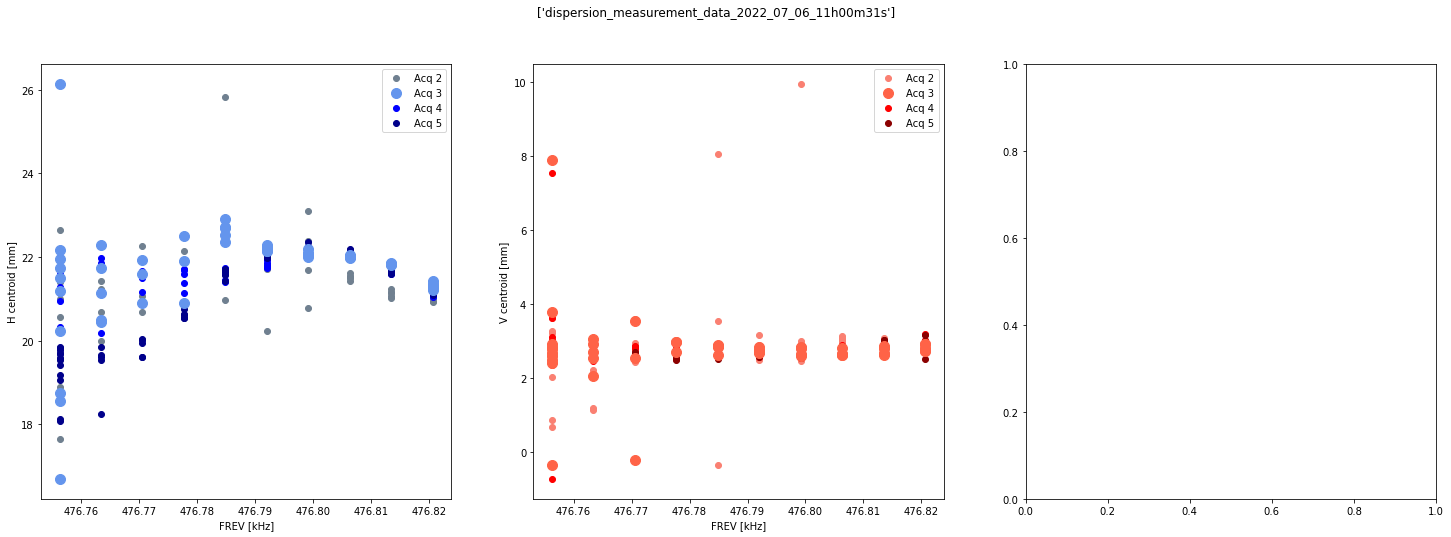

In [35]:
fig, ax = plt.subplots(1,3, figsize=(25,8))

df_acq = df[df.Acqu==2].copy()
ax[0].scatter(df_acq.frev, df_acq.poptH2_cal, color="slategray", label="Acq 2")
ax[1].scatter(df_acq.frev, df_acq.poptV2_cal, color="salmon", label="Acq 2")


df_acq = df[df.Acqu==3].copy()
ax[0].scatter(df_acq.frev, df_acq.poptH2_cal, color="cornflowerblue", s=100, label="Acq 3", zorder=99)
ax[1].scatter(df_acq.frev, df_acq.poptV2_cal, color="tomato", s=100, label="Acq 3", zorder=99)

# ax[0].plot(df_acq.frev, df_acq.poptH2_cal, color="cornflowerblue", label="Acq 3", zorder=99)
# ax[1].plot(df_acq.frev, df_acq.poptV2_cal, color="tomato", label="Acq 3", zorder=99)

df_acq = df[df.Acqu==4].copy()
ax[0].scatter(df_acq.frev, df_acq.poptH2_cal, color="blue", label="Acq 4")
ax[1].scatter(df_acq.frev, df_acq.poptV2_cal, color="red", label="Acq 4")

df_acq = df[df.Acqu==5].copy()
ax[0].scatter(df_acq.frev, df_acq.poptH2_cal, color="darkblue", label="Acq 5")
ax[1].scatter(df_acq.frev, df_acq.poptV2_cal, color="darkred", label="Acq 5")

ax[0].legend()
ax[1].legend()

ax[0].set_xlabel("FREV [kHz]")
ax[0].set_ylabel("H centroid [mm]")

ax[1].set_xlabel("FREV [kHz]")
ax[1].set_ylabel("V centroid [mm]")

# df_acq.reset_index(drop=True, inplace=True)
# ax[2].plot(df_acq.k_qfn01, label="k_qfn01")
# ax[2].plot(df_acq.k_qdn02, label="k_qdn02")
# ax[2].plot(df_acq.k_qfn03, label="k_qfn03")
# ax[2].set_xlabel("shot number")
# ax[2].set_ylabel("k")
# ax[2].legend()
fig.suptitle(f"{subset_dirnames}")
fig.savefig("fig/"+str(subset_dirnames[0])+".png", facecolor='white', transparent=False, bbox_inches='tight');

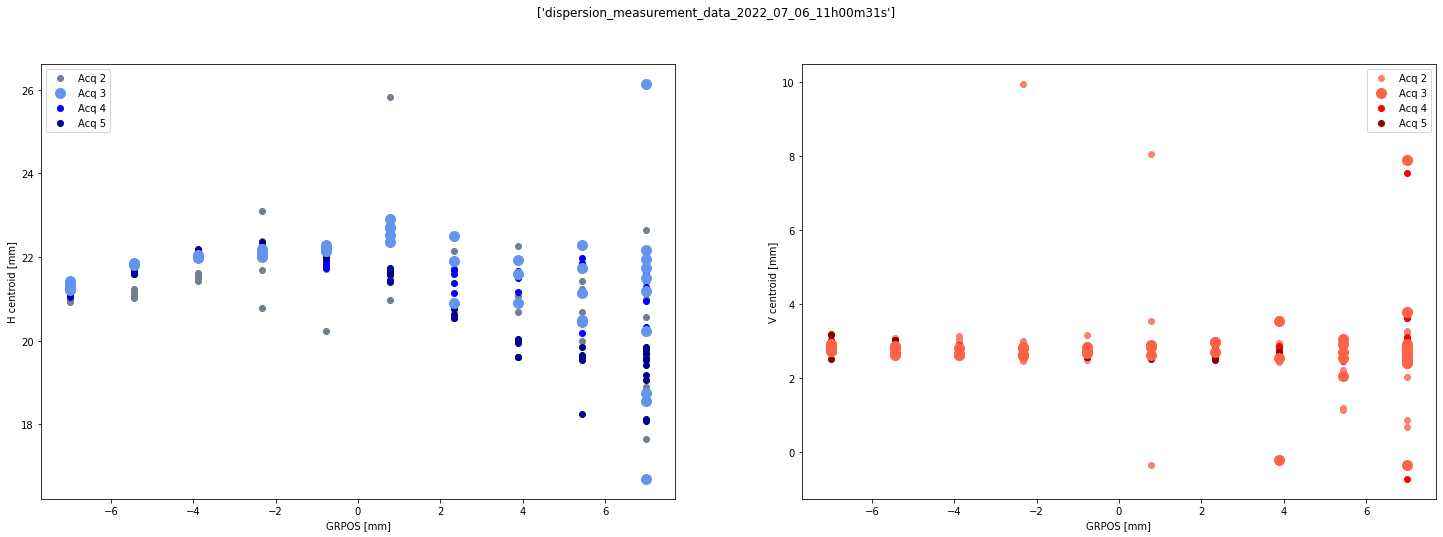

In [36]:
fig, ax = plt.subplots(1,2, figsize=(25,8))

df_acq = df[df.Acqu==2].copy()
ax[0].scatter(df_acq.grpos, df_acq.poptH2_cal, color="slategray", label="Acq 2")
ax[1].scatter(df_acq.grpos, df_acq.poptV2_cal, color="salmon", label="Acq 2")


df_acq = df[df.Acqu==3].copy()
ax[0].scatter(df_acq.grpos, df_acq.poptH2_cal, color="cornflowerblue", s=100, label="Acq 3", zorder=99)
ax[1].scatter(df_acq.grpos, df_acq.poptV2_cal, color="tomato", s=100, label="Acq 3", zorder=99)

# ax[0].plot(df_acq.frev, df_acq.poptH2_cal, color="cornflowerblue", label="Acq 3", zorder=99)
# ax[1].plot(df_acq.frev, df_acq.poptV2_cal, color="tomato", label="Acq 3", zorder=99)

df_acq = df[df.Acqu==4].copy()
ax[0].scatter(df_acq.grpos, df_acq.poptH2_cal, color="blue", label="Acq 4")
ax[1].scatter(df_acq.grpos, df_acq.poptV2_cal, color="red", label="Acq 4")

df_acq = df[df.Acqu==5].copy()
ax[0].scatter(df_acq.grpos, df_acq.poptH2_cal, color="darkblue", label="Acq 5")
ax[1].scatter(df_acq.grpos, df_acq.poptV2_cal, color="darkred", label="Acq 5")

ax[0].legend()
ax[1].legend()

ax[0].set_xlabel("GRPOS [mm]")
ax[0].set_ylabel("H centroid [mm]")

ax[1].set_xlabel("GRPOS [mm]")
ax[1].set_ylabel("V centroid [mm]")


fig.suptitle(f"{subset_dirnames}")
fig.savefig("fig/"+str(subset_dirnames[0])+".png", facecolor='white', transparent=False, bbox_inches='tight');

# Median position of the acquisitions

/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarnin

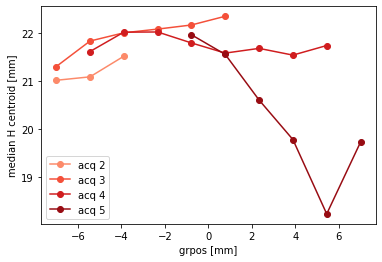

In [37]:
fig, ax = plt.subplots()

color = iter(cm.Reds(np.linspace(0.4, 0.9, len([2,3,4,5]))))

for acq in ([2,3,4,5]):
    c = next(color)
    median_muH_list = []
    for grpos in (np.unique(df.grpos)):
        median_muH = np.median(df.loc[(df.Acqu == acq) & (df.grpos == grpos) & (df.poptH2_cal.isna() == False) & (df.muErrH_cal < 0.5) & (df.gaussian_maxH > 100) & (df.gaussian_maxV > 100) & (df.Saturation < 30)].poptH2_cal)
        median_muH_list.append(median_muH)

    ax.plot(np.unique(df.grpos), median_muH_list, marker="o", color=c, label=f"acq {acq}")
ax.set_xlabel("grpos [mm]")
ax.set_ylabel("median H centroid [mm]")
ax.legend()

# Show images where I make the fit

In [38]:
color = iter(cm.Reds(np.linspace(0.4, 0.9, len([2,3,4,5]))))

for acq in ([5]):
    c = next(color)
    median_muH_list = []
    for grpos in ([-7]):
        for i in range(len(df.loc[(df.Acqu == acq) & (df.grpos == grpos) & (df.poptH2_cal.isna() == False) & (df.muErrH_cal < 0.5) & (df.gaussian_maxH > 100) & (df.gaussian_maxV > 100)].Image_processed_masked)):
            image = df.loc[(df.Acqu == acq) & (df.grpos == grpos) & (df.poptH2_cal.isna() == False) & (df.muErrH_cal < 0.5) & (df.gaussian_maxH > 100) & (df.gaussian_maxV > 100)].iloc[i].Image_processed_masked
            fig, ax = plt.subplots()
            ax.imshow(image)

# ax.set_xlabel("grpos [mm]")
# ax.set_ylabel("median H centroid [mm]")
# ax.legend()

# Vertical dispersion

/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarnin

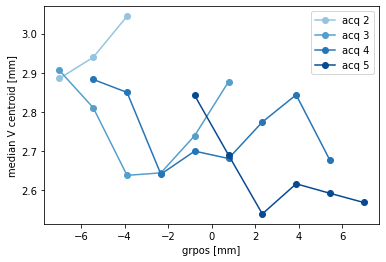

In [39]:
fig, ax = plt.subplots()

color = iter(cm.Blues(np.linspace(0.4, 0.9, len([2,3,4,5]))))

for acq in ([2,3,4,5]):
    c = next(color)
    median_muV_list = []
    for grpos in (np.unique(df.grpos)):
        median_muV = np.median(df.loc[(df.Acqu == acq) & (df.grpos == grpos) & (df.poptV2_cal.isna() == False) & (df.muErrV_cal < 0.5) & (df.gaussian_maxH > 100) & (df.gaussian_maxV > 100) & (df.Saturation < 30)].poptV2_cal)
        median_muV_list.append(median_muV)

    ax.plot(np.unique(df.grpos), median_muV_list, marker="o", color=c, label=f"acq {acq}")
ax.set_xlabel("grpos [mm]")
ax.set_ylabel("median V centroid [mm]")
ax.legend()

(array([151.,  11.,   6.,   7.,  17.,  31.,  18.,  15.,   8.,   3.]),
 array([9.78125979e-05, 2.97464879e-02, 5.93951632e-02, 8.90438385e-02,
        1.18692514e-01, 1.48341189e-01, 1.77989864e-01, 2.07638540e-01,
        2.37287215e-01, 2.66935890e-01, 2.96584566e-01]),
 <BarContainer object of 10 artists>)

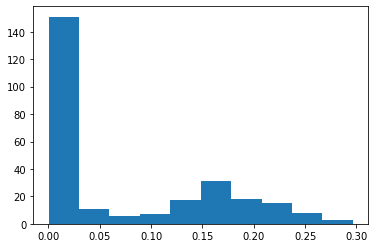

In [40]:
fig, ax = plt.subplots()
ax.hist(df.loc[~df.muErrH_cal.isin([np.inf, np.nan]) & (df.muErrH < 1)].muErrH_cal)

(array([125.,  29.,   5.,   1.,   4.,   1.,  10.,  31.,  14.,  20.]),
 array([0.00118571, 0.0352911 , 0.06939649, 0.10350188, 0.13760728,
        0.17171267, 0.20581806, 0.23992345, 0.27402884, 0.30813423,
        0.34223962]),
 <BarContainer object of 10 artists>)

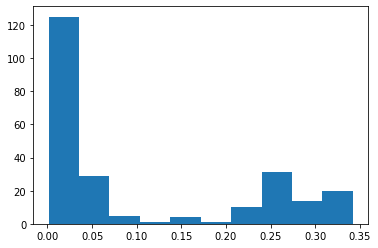

In [41]:
fig, ax = plt.subplots()
ax.hist(df.loc[~df.muErrV_cal.isin([np.inf, np.nan]) & (df.muErrV < 1)].muErrV_cal)

18.9


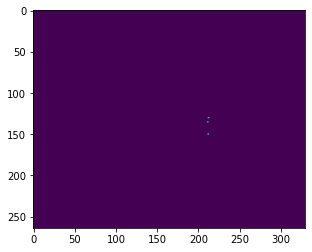

In [42]:
fig, ax = plt.subplots()
ax.imshow(df.loc[(df.Acqu == 2) & (df.grpos == 7) & (df.poptH2_cal.isna() == False) & (df.muErrH_cal < 0.1)].iloc[0].Image_processed_masked)
print(df.loc[(df.Acqu == 2) & (df.grpos == 7) & (df.poptH2_cal.isna() == False) & (df.muErrH_cal < 0.1)].iloc[0].poptH2_cal)

# Look at why certain images make a good fit but actually the images are empty ???

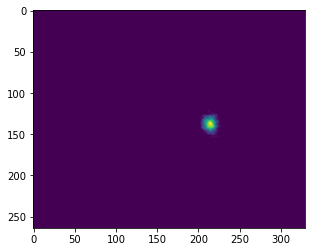

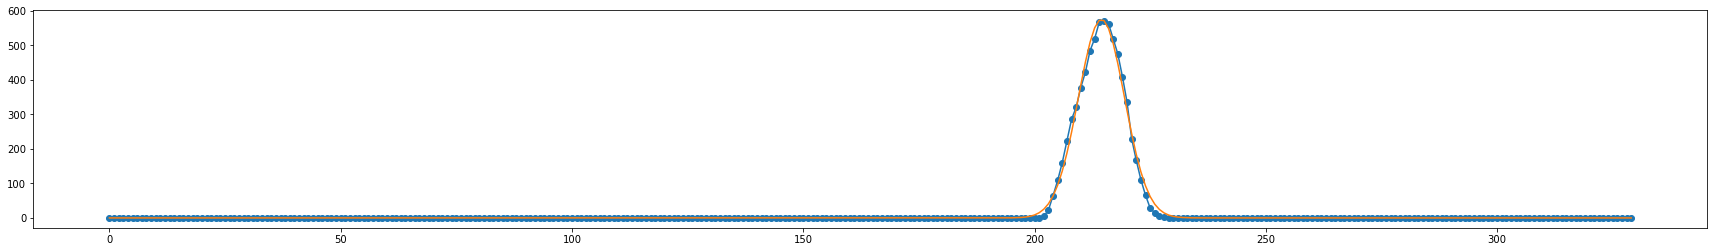

In [43]:
image_processed_masked = df.loc[(df.Acqu == 5) & (df.grpos == 7) & (df.poptH2_cal.isna() == False)].iloc[9].Image_processed_masked

fig, ax = plt.subplots()
ax.imshow(image_processed_masked)

fig, ax = plt.subplots(figsize=(30,4))

Hy = image_processed_masked.sum(axis=0)
Hx = np.linspace(0, len(Hy)-1, len(Hy))

ax.plot(Hx, Hy,marker="o")

# H
poptH, pcovH = do_gaussian_fit(Hx, Hy)

ax.plot(Hx, gaussian_function(Hx, poptH[0], poptH[1], poptH[2], poptH[3]))

# Signal as a function of GSRPOS

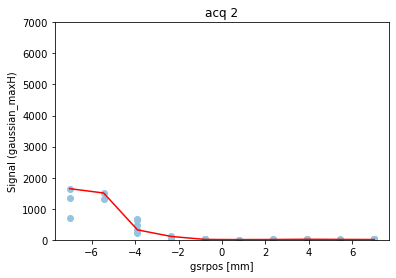

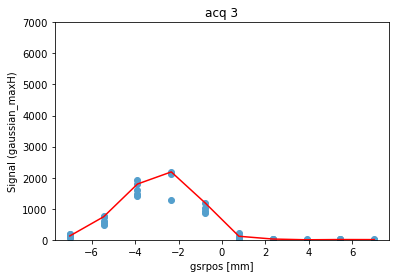

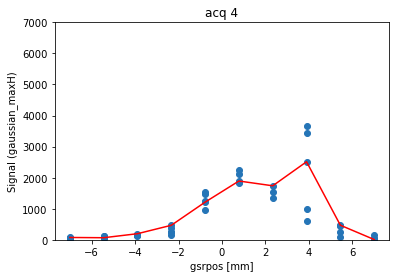

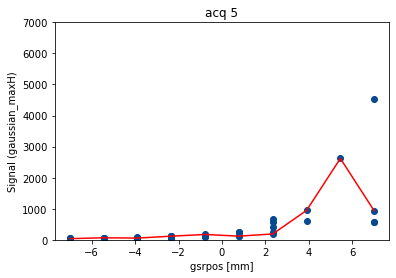

In [44]:
color = iter(cm.Blues(np.linspace(0.4, 0.9, len([2,3,4,5]))))

for acq in ([2,3,4,5]):
    fig, ax = plt.subplots()
    c = next(color)
    y_median = []
    for grpos in (np.unique(df.grpos)):
        y = []
        
        mini_df = df.loc[(df.Acqu == acq) & (df.grpos == grpos) & (df.poptH2_cal.isna() == False) & ~df.gaussian_maxH.isin([np.inf, np.nan]) & (df.Saturation < 30)]
        for i in range(len(mini_df)):
            y.append(mini_df.iloc[i].gaussian_maxH)
        y_median.append(np.median(mini_df.iloc[i].gaussian_maxH))
#         print(f"acq{acq} grpos {grpos} y_median {y_median}")

        ax.scatter(np.ones(len(y))*grpos, y, color=c)
    ax.plot(np.unique(df.grpos), y_median, color="r", label=f"acq {acq}")

    ax.set_ylim(0,7000)
    ax.set_title(f"acq {acq}")
    ax.set_ylabel("Signal (gaussian_maxH)")
    ax.set_xlabel("gsrpos [mm]")

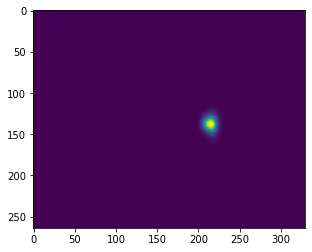

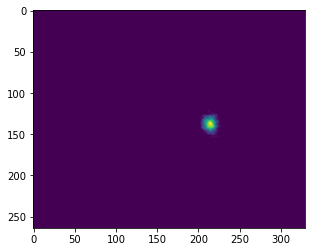

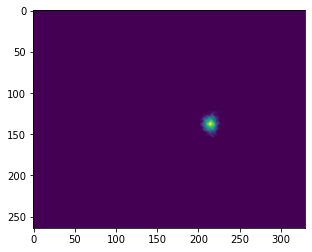

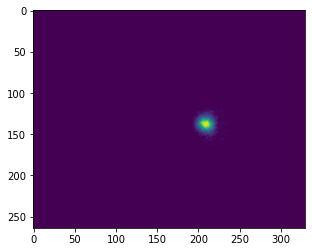

In [45]:
mini_df = df.loc[(df.Acqu == 5) & (df.grpos == 7) & (df.poptH2_cal.isna() == False) & ~df.gaussian_maxH.isin([np.inf, np.nan]) & (df.Saturation < 30)]

for i in range(len(mini_df)):
    fig, ax = plt.subplots()
    ax.imshow(mini_df.iloc[i].Image_processed_masked)

In [46]:
mini_df = df.loc[(df.Acqu == 5) & (df.grpos == 7) & (df.poptH2_cal.isna() == False) & ~df.gaussian_maxH.isin([np.inf, np.nan])]

fig, ax = plt.subplots()
ax.scatter(mini_df.poptH2_cal, mini_df.gaussian_maxH)

Text(0, 0.5, 'Signal H')

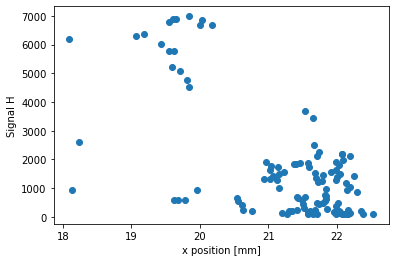

In [47]:
mini_df = df.loc[(df.poptH2_cal.isna() == False) & ~df.gaussian_maxH.isin([np.inf, np.nan]) & (df.gaussian_maxH > 100)]

fig, ax = plt.subplots()
ax.scatter(mini_df.poptH2_cal, mini_df.gaussian_maxH)
ax.set_xlabel("x position [mm]")
ax.set_ylabel("Signal H")



Text(0.5, 1.0, 'Saturation')

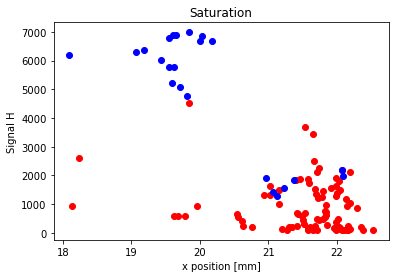

In [48]:
fig, ax = plt.subplots()

mini_df = df.loc[(df.poptH2_cal.isna() == False) & ~df.gaussian_maxH.isin([np.inf, np.nan]) & (df.gaussian_maxH > 100) & (df.Saturation < 30)]
ax.scatter(mini_df.poptH2_cal, mini_df.gaussian_maxH, color="r")

mini_df = df.loc[(df.poptH2_cal.isna() == False) & ~df.gaussian_maxH.isin([np.inf, np.nan]) & (df.gaussian_maxH > 100) & (df.Saturation > 30)]
ax.scatter(mini_df.poptH2_cal, mini_df.gaussian_maxH, color="b")

ax.set_xlabel("x position [mm]")
ax.set_ylabel("Signal H")
ax.set_title("Saturation")

(array([306.,  21.,   0.,   2.,   1.,   0.,   2.,   2.,   4.,   4.]),
 array([  0. ,  25.1,  50.2,  75.3, 100.4, 125.5, 150.6, 175.7, 200.8,
        225.9, 251. ]),
 <BarContainer object of 10 artists>)

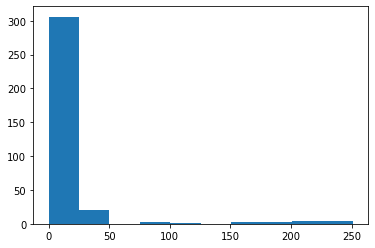

In [49]:
fig, ax = plt.subplots()
ax.hist(df.Saturation)

# MuH during a spill at different GRPOS

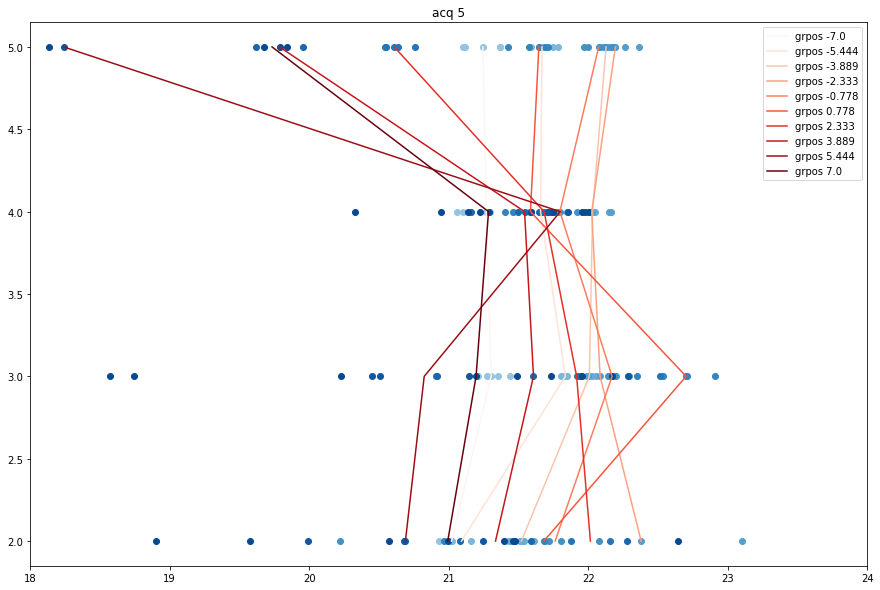

In [50]:
acq_list = [2,3,4,5]
color = iter(cm.Blues(np.linspace(0.4, 0.9, len(np.unique(df.grpos)))))
colorR = iter(cm.Reds(np.linspace(0.0, 1.0, len(np.unique(df.grpos)))))

fig, ax = plt.subplots(figsize=(15,10))
for grpos in np.unique(df.grpos):
    c = next(color)
    cR = next(colorR)
    y_median = []
    for acq in (acq_list):
        y = []
        
        mini_df = df.loc[(df.Acqu == acq) & (df.grpos == grpos) & (df.poptH2_cal.isna() == False) & ~df.gaussian_maxH.isin([np.inf, np.nan]) & (df.Saturation < 30)]
        for i in range(len(mini_df)):
            y.append(mini_df.iloc[i].poptH2_cal)
        y_median.append(np.median(mini_df.poptH2_cal))

        ax.scatter(y, np.ones(len(y))*acq, color=c)
    ax.plot(y_median, acq_list, color=cR, zorder = 99, label=f"grpos {round(grpos,3)}")

    ax.set_xlim(18,24)
    ax.set_title(f"acq {acq}")
#     ax.set_ylabel("Signal (gaussian_maxH)")
#     ax.set_xlabel("gsrpos [mm]")
    ax.legend()

-7.0
-5.444444444444445
-3.888888888888889
-2.333333333333333
-0.7777777777777777
0.7777777777777777
2.333333333333334
3.8888888888888893


/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarnin

5.444444444444445
7.0


/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarnin

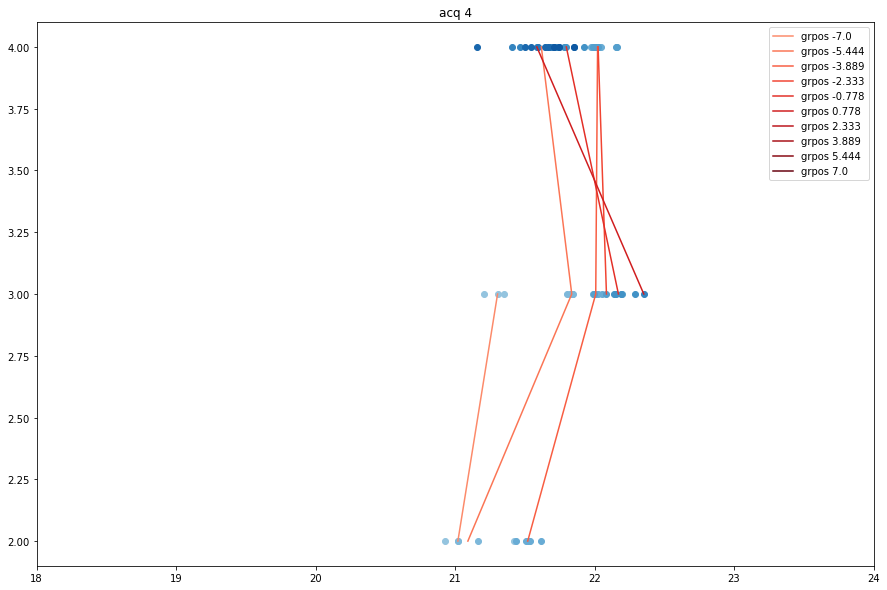

In [51]:
acq_list = [2,3,4]
grpos_list = np.unique(df.grpos)[::]
# grpos_list = np.array([-2.333333333333333])
color = iter(cm.Blues(np.linspace(0.4, 0.9, len(np.unique(df.grpos)))))
colorR = iter(cm.Reds(np.linspace(0.4, 1.0, len(grpos_list))))

fig, ax = plt.subplots(figsize=(15,10))
for grpos in grpos_list:
    print(grpos)
    c = next(color)
    cR = next(colorR)
    y_median = []
    for acq in (acq_list):
        y = []
        
        mini_df = df.loc[(df.Acqu == acq) & (df.grpos == grpos) & (df.poptH2_cal.isna() == False) & ~df.gaussian_maxH.isin([np.inf, np.nan]) & (df.muErrH_cal < 0.5) & (df.gaussian_maxH > 100) & (df.gaussian_maxV > 100) & (df.Saturation < 30)]
        for i in range(len(mini_df)):
            y.append(mini_df.iloc[i].poptH2_cal)
        y_median.append(np.median(mini_df.poptH2_cal))

        ax.scatter(y, np.ones(len(y))*acq, color=c)
    ax.plot(y_median, acq_list, color=cR, zorder = 99, label=f"grpos {round(grpos,3)}")

    ax.set_xlim(18,24)
    ax.set_title(f"acq {acq}")
#     ax.set_ylabel("Signal (gaussian_maxH)")
#     ax.set_xlabel("gsrpos [mm]")
    ax.legend()

-5.444444444444445
-3.888888888888889
-2.333333333333333
-0.7777777777777777


/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


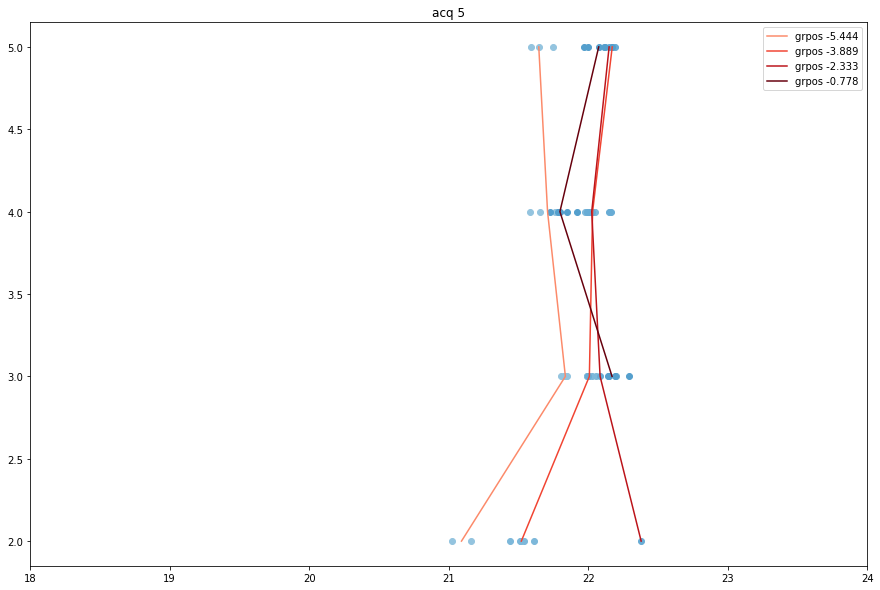

In [52]:
acq_list = [2,3,4,5]
grpos_list = np.unique(df.grpos)[1:5:]
# grpos_list = np.array([-2.333333333333333])
color = iter(cm.Blues(np.linspace(0.4, 0.9, len(np.unique(df.grpos)))))
colorR = iter(cm.Reds(np.linspace(0.4, 1.0, len(grpos_list))))

fig, ax = plt.subplots(figsize=(15,10))
for grpos in grpos_list:
    print(grpos)
    c = next(color)
    cR = next(colorR)
    y_median = []
    for acq in (acq_list):
        y = []
        
        mini_df = df.loc[(df.Acqu == acq) & (df.grpos == grpos) & (df.poptH2_cal.isna() == False) & ~df.gaussian_maxH.isin([np.inf, np.nan]) & (df.muErrH_cal < 0.5) & (df.gaussian_maxH > 50) & (df.gaussian_maxV > 50) & (df.Saturation < 30)]
        for i in range(len(mini_df)):
            y.append(mini_df.iloc[i].poptH2_cal)
        y_median.append(np.median(mini_df.poptH2_cal))

        ax.scatter(y, np.ones(len(y))*acq, color=c)
    ax.plot(y_median, acq_list, color=cR, zorder = 99, label=f"grpos {round(grpos,3)}")

    ax.set_xlim(18,24)
    ax.set_title(f"acq {acq}")
#     ax.set_ylabel("Signal (gaussian_maxH)")
#     ax.set_xlabel("gsrpos [mm]")
    ax.legend()

0.0143928943282678
114.41155638572168
87.1917200582243


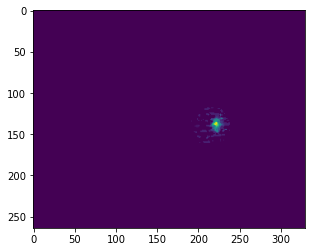

In [53]:
mini_df = df.loc[(df.Acqu == 5) & (df.grpos == -2.333333333333333) & (df.poptH2_cal.isna() == False) & ~df.gaussian_maxH.isin([np.inf, np.nan])
                 #& (df.muErrH_cal < 0.5) & (df.gaussian_maxH > 100) & (df.gaussian_maxV > 100) & (df.Saturation < 30000)
                ]

fig, ax = plt.subplots()
ax.imshow(mini_df.iloc[0].Image_processed_masked)
print (mini_df.iloc[0].muErrH_cal)
print (mini_df.iloc[0].gaussian_maxH)
print (mini_df.iloc[0].gaussian_maxV)

# Comparing position vs time in spill
# We superimpose all the spill one on top of each other to compare spill by spill

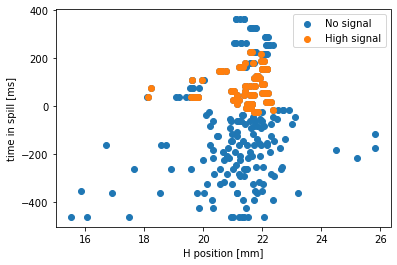

In [54]:
fig, ax = plt.subplots()

mini_df = df.loc[(df.poptH2_cal.isna() == False) & ~df.gaussian_maxH.isin([np.inf, np.nan])
                 #& (df.muErrH_cal < 0.5) & (df.gaussian_maxH > 100) & (df.gaussian_maxV > 100) & (df.Saturation < 30000)
                ]

ax.scatter(mini_df.poptH2_cal, mini_df.time_spill, label="No signal")

mini_df = df.loc[(df.poptH2_cal.isna() == False) & ~df.gaussian_maxH.isin([np.inf, np.nan])
                 & (df.muErrH_cal < 0.5) & (df.gaussian_maxH > 100) & (df.gaussian_maxV > 100) & (df.Saturation < 100)
                ]

ax.scatter(mini_df.poptH2_cal, mini_df.time_spill, label="High signal")
ax.set_ylabel("time in spill [ms]")
ax.set_xlabel("H position [mm]")
ax.legend()

In [74]:
fig, ax = plt.subplots(figsize=(15,10))
color = iter(cm.seismic(np.linspace(0.2, 0.8, len(np.unique(df.grpos)))))
colorG = iter(cm.Greys(np.linspace(0.0, 1.0, len(np.unique(df.grpos)))))
for grpos in (df.grpos.unique()):
    c=next(color)
    cG=next(colorG)
    mini_df = df.loc[(df.poptH2_cal.isna() == False) & ~df.gaussian_maxH.isin([np.inf, np.nan])
                     & (df.grpos == grpos)
                     #& (df.muErrH_cal < 0.5) & (df.gaussian_maxH > 100) & (df.gaussian_maxV > 100) & (df.Saturation < 30000)
                    ]

    ax.scatter(mini_df.poptH2_cal, mini_df.time_spill, color=cG)

    mini_df = df.loc[(df.poptH2_cal.isna() == False) & ~df.gaussian_maxH.isin([np.inf, np.nan])
                     & (df.muErrH_cal < 0.5) & (df.gaussian_maxH > 100) & (df.gaussian_maxV > 100)
#                      & (df.Saturation < 100)
                     & (df.grpos == grpos)
                    ]

    ax.scatter(mini_df.poptH2_cal, mini_df.time_spill, label=f"grpos {round(grpos,3)}", color=c)
    ax.set_ylabel("Time in spill [ms]")
    ax.set_xlabel("H position [mm]")
    ax.legend()
#     ax.set_ylim(-500,500)
#     ax.set_xlim(16,24)
    ax.set_title(f"grpos {grpos}")
    ax.axhline(0)
    ax.axhline(200)

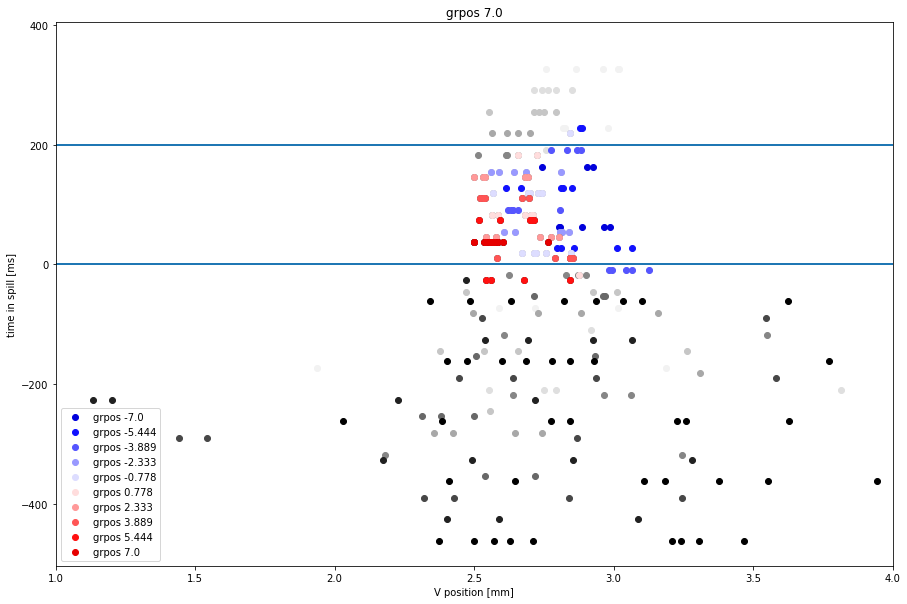

In [78]:
fig, ax = plt.subplots(figsize=(15,10))
color = iter(cm.seismic(np.linspace(0.2, 0.8, len(np.unique(df.grpos)))))
colorG = iter(cm.Greys(np.linspace(0.0, 1.0, len(np.unique(df.grpos)))))
for grpos in (df.grpos.unique()):
    c=next(color)
    cG=next(colorG)
    mini_df = df.loc[(df.poptV2_cal.isna() == False) & ~df.gaussian_maxV.isin([np.inf, np.nan])
                     & (df.grpos == grpos)
                     #& (df.muErrH_cal < 0.5) & (df.gaussian_maxH > 100) & (df.gaussian_maxV > 100) & (df.Saturation < 30000)
                    ]

    ax.scatter(mini_df.poptV2_cal, mini_df.time_spill, color=cG)

    mini_df = df.loc[(df.poptV2_cal.isna() == False) & ~df.gaussian_maxH.isin([np.inf, np.nan])
                     & (df.muErrV_cal < 0.5) & (df.gaussian_maxH > 100) & (df.gaussian_maxV > 100)
#                      & (df.Saturation < 100)
                     & (df.grpos == grpos)
                    ]

    ax.scatter(mini_df.poptV2_cal, mini_df.time_spill, label=f"grpos {round(grpos,3)}", color=c)
    ax.set_ylabel("time in spill [ms]")
    ax.set_xlabel("V position [mm]")
    ax.legend()
#     ax.set_ylim(-500,500)
    ax.set_xlim(1,4)
    ax.set_title(f"grpos {grpos}")
    ax.axhline(0)
    ax.axhline(200)

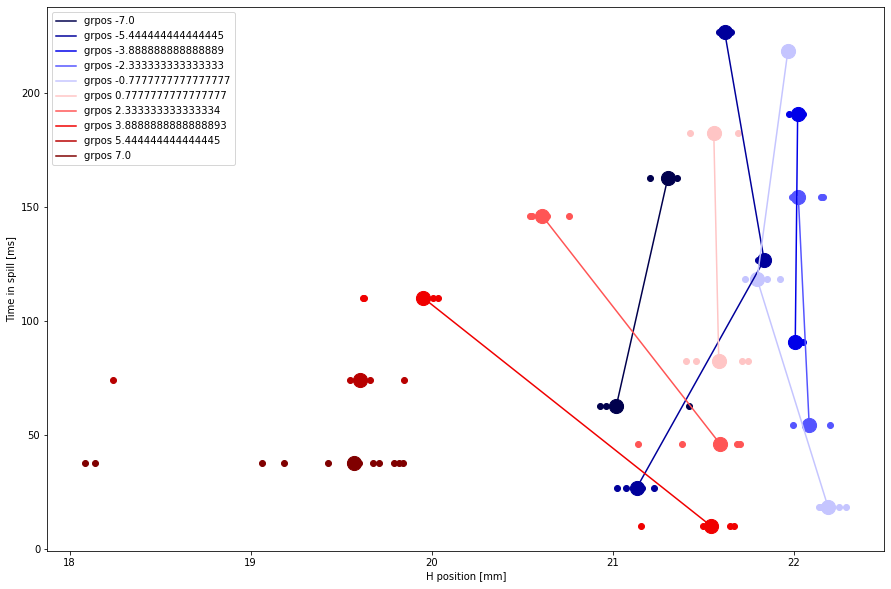

In [62]:
fig, ax = plt.subplots(figsize=(15,10))

color = iter(cm.seismic(np.linspace(0.0, 1.0, len(np.unique(df.grpos)))))
for grpos in (df.grpos.unique()):
    c = next(color)
    mini_df = df.loc[(df.poptH2_cal.isna() == False) & ~df.gaussian_maxH.isin([np.inf, np.nan])
                     & (df.muErrH_cal < 0.5) & (df.gaussian_maxH > 100) & (df.gaussian_maxV > 100)
#                      & (df.Saturation < 100)
                     & (df.grpos == grpos)
                     & (df.time_spill > 0)
#                      & (df.time_spill < 50)
                    ]

    ax.scatter(mini_df.poptH2_cal, mini_df.time_spill, color=c)
    med_mu_list = []
    ctime_list = []
    for ctime in mini_df.time_spill.unique():
        med_mu = mini_df.loc[(mini_df.time_spill == ctime)].poptH2_cal.median()
        ax.scatter(med_mu, ctime, s=200, color=c)
        med_mu_list.append(med_mu)
        ctime_list.append(ctime)
    ax.plot(med_mu_list, ctime_list, label=f"grpos {grpos}", color=c)
        
ax.set_ylabel("Time in spill [ms]")
ax.set_xlabel("H position [mm]")
ax.legend()

(19.0, 23.0)

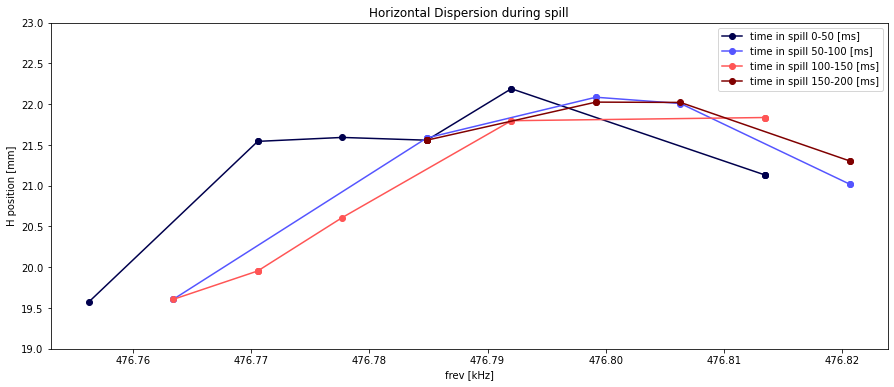

In [85]:
fig, ax = plt.subplots(figsize=(15,6))



later_in_spill_list = [0, 50, 100, 150]

color = iter(cm.seismic(np.linspace(0.0, 1.0, len(later_in_spill_list))))
for later_in_spill in later_in_spill_list:    
    frev_list = []
    med_mu_list = []
    c = next(color)
    for grpos in (df.grpos.unique()):
        mini_df = df.loc[~df.gaussian_maxH.isin([np.inf, np.nan])
                         & (df.muErrH_cal < 0.5) 
                         & (df.gaussian_maxH > 100) 
                         & (df.gaussian_maxV > 100) 
#                          & (df.Saturation < 100)
                         & (df.grpos == grpos)
                         & (df.time_spill > 0+later_in_spill)
                         & (df.time_spill < 50+later_in_spill)
                        ]

        for ctime in mini_df.time_spill.unique():
            med_mu = mini_df.loc[(mini_df.time_spill == ctime)].poptH2_cal.median()
            frev =  mini_df.loc[(mini_df.time_spill == ctime)].frev.median()

    #         ax.scatter(mini_df.loc[(mini_df.time_spill == ctime)].frev, mini_df.loc[(mini_df.time_spill == ctime)].poptH2_cal, color=c)

    #     ax.scatter(frev, med_mu, label=f"grpos {grpos}", color=c , s =200)
        frev_list.append(frev)
        med_mu_list.append(med_mu)

    frev_df = pd.DataFrame(data={"frev": frev_list, "med_mu": med_mu_list})

    ax.plot(frev_df.sort_values(by=["frev"]).frev, frev_df.sort_values(by=["frev"]).med_mu, marker="o", c=c, label=f"time in spill {later_in_spill}-{50+later_in_spill} [ms]")

ax.legend()
ax.set_xlabel("frev [kHz]")
ax.set_ylabel("H position [mm]")
ax.set_title("Horizontal Dispersion during spill")
ax.set_ylim(19,23)

In [83]:
fig, ax = plt.subplots(figsize=(15,6))


later_in_spill_list = [0, 50, 100,150]

color = iter(cm.seismic(np.linspace(0.0, 1.0, len(later_in_spill_list))))
for later_in_spill in later_in_spill_list:
    frev_list = []
    med_mu_list = []
    c = next(color)
    for grpos in (df.grpos.unique()):
        mini_df = df.loc[~df.gaussian_maxV.isin([np.inf, np.nan])
                         & (df.muErrV_cal < 0.5) 
                         & (df.gaussian_maxH > 100) 
                         & (df.gaussian_maxV > 100) 
#                          & (df.Saturation < 100)
                         & (df.grpos == grpos)
                         & (df.time_spill > 0+later_in_spill)
                         & (df.time_spill < 50+later_in_spill)
                        ]

        for ctime in mini_df.time_spill.unique():
            med_mu = mini_df.loc[(mini_df.time_spill == ctime)].poptV2_cal.median()
            frev =  mini_df.loc[(mini_df.time_spill == ctime)].frev.median()

    #         ax.scatter(mini_df.loc[(mini_df.time_spill == ctime)].frev, mini_df.loc[(mini_df.time_spill == ctime)].poptH2_cal, color=c)

    #     ax.scatter(frev, med_mu, label=f"grpos {grpos}", color=c , s =200)
        frev_list.append(frev)
        med_mu_list.append(med_mu)

    frev_df = pd.DataFrame(data={"frev": frev_list, "med_mu": med_mu_list})

    ax.plot(frev_df.sort_values(by=["frev"]).frev, frev_df.sort_values(by=["frev"]).med_mu, marker="o", c=c, label=f"time in spill {later_in_spill} {50+later_in_spill} [ms]")

# Linear regression

frev_list = []
med_mu_list = []
for grpos in (df.grpos.unique()):
    mini_df = df.loc[~df.gaussian_maxV.isin([np.inf, np.nan])
                     & (df.muErrV_cal < 0.5) 
                     & (df.gaussian_maxH > 100) 
                     & (df.gaussian_maxV > 100) 
                     & (df.Saturation < 100)
                     & (df.grpos == grpos)
                     & (df.time_spill > 0)
                     & (df.time_spill < 200)
                    ]

    for ctime in mini_df.time_spill.unique():
        med_mu = mini_df.loc[(mini_df.time_spill == ctime)].poptV2_cal.median()
        frev =  mini_df.loc[(mini_df.time_spill == ctime)].frev.median()


    frev_list.append(frev)
    med_mu_list.append(med_mu)

frev_df = pd.DataFrame(data={"frev": frev_list, "med_mu": med_mu_list})
x = frev_df.sort_values(by=["frev"]).frev
y = frev_df.sort_values(by=["frev"]).med_mu

res = stats.linregress(x, y)
ax.plot(x, res.intercept + res.slope*x, color="b", linewidth=5, linestyle="--", label=f"f(x) = {round(res.slope,5)}x + {round(res.intercept,3)}")


    
ax.legend()
ax.set_xlabel("frev [kHz]")
ax.set_ylabel("V position [mm]")
ax.set_title("Vertical Dispersion during spill")
ax.set_ylim(1,5)

(1.0, 5.0)